<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sentiment-changes-over-time" data-toc-modified-id="Sentiment-changes-over-time-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sentiment changes over time</a></span></li><li><span><a href="#Senders'-Sentiment" data-toc-modified-id="Senders'-Sentiment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Senders' Sentiment</a></span></li><li><span><a href="#visualize-outliers" data-toc-modified-id="visualize-outliers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>visualize outliers</a></span></li></ul></div>

In [113]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from datetime import datetime

from tqdm import tqdm_notebook
import re
from function_library import *
from function_library2 import *
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 16})

In [339]:
df = pd.read_csv('output6_triplets_names.csv',index_col = 0)
df['Sent'] = pd.to_datetime(df['Sent'])
df


,From,Sent,To,CC,Subject,Attachments,Importance,Body,textblob_sentiment,nltk_sentiment
0,"('cindy', 'dick', 'cynthia.dick@talgov.com')",2011-08-18 12:12:00,"[('fire', 'department', 'fire_department')]",[],[],[],[],['I recently came across this quote and reflec...,"[0.275, 0.39583333333333337]","[0.0, 0.149, 0.701, 0.149]"
1,"('mark', 'decarlo', 'mark.decarlo@talgov.com')",2011-08-20 03:44:00,"[('fire', 'department', 'fire_department')]",[],[],[],[],[''],"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"
2,"('deborah', 'heiter', 'deborah.heiter@talgov.c...",2012-01-20 16:41:00,"[('bill', 'behenna', 'bill_behenna'), ('cathy'...",[],[],[],[],"['', 'Deborah L. Heiter', 'Administrative Spec...","[0.07253787878787879, 0.3424242424242424]","[0.9318, 0.0, 0.93, 0.07]"
3,"('beth', 'kirkland', 'bkirkland@taledc.com')",2012-01-23 09:32:00,"[('f496', 'l496', 'llaubscher@eflorida.com')]","[('f18020', 'l18020', 'brook.pace@deo.myflorid...",[],[],[],"['Louis,', 'Thank you for meeting with us in F...","[0.012500000000000011, 0.36944444444444446]","[0.9599, 0.021, 0.847, 0.132]"
4,"('vida', 'addison', 'vida.addison@talgov.com')",2012-02-07 15:19:00,"[(""gary yordon' no, they have not told me anyt...",[],[],[],[],"['Hello, Do you have a 4meline for when a deci...","[0.021875000000000006, 0.403125]","[0.8708, 0.0, 0.879, 0.121]"
...,...,...,...,...,...,...,...,...,...,...
21809,"('gina', 'fletcher', 'gfletcher@leonpa.org')",2017-09-26 11:12:00,"[('vince', 'long', 'longv@leoncountyfl.gov'), ...","[('f22301', 'l22301', 'rosss@leoncountyfl.gov'...",[],[],"[""High Good morning, everyone! I have been c...",[],"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"
21810,"('alison', 'faris', 'alison.faris@talgov.com')",2017-09-26 11:20:00,"[('suzanne', 'hughes', 'suzanneh@floridarealto...","[('paige', 'carter-smith', 'paige.tallahasseed...",[],[],[],"['', 'Thanks for leqng us know about your plan...","[0.2333333333333333, 0.4000000000000001]","[0.9001, 0.0, 0.842, 0.158]"
21811,"('suzanne', 'hughes', 'suzanneh@floridarealtor...",2017-09-26 13:41:00,"[('alison', 'faris', 'afaris@comcast.net')]","[('paige', 'carter-smith', 'paige.tallahasseed...",[],[],[],"['', '', 'Great! And yes, wed love to let eve...","[0.625, 0.5166666666666667]","[0.9421, 0.0, 0.377, 0.623]"
21812,"('edward', 'kring', 'edward.kring@talgov.com')",2017-09-26 17:48:00,"[('suzanne', 'hughes', 'suzanneh@floridarealto...","[('paige', 'carter-smith', 'paige.tallahasseed...",[],[],[],"['', 'HI Suzanne I hope this nds you well. Pl...","[-0.75, 1.0]","[0.891, 0.0, 0.741, 0.259]"


In [348]:
df = df.drop_duplicates(subset=['Sent','From'])
df = df.reset_index(drop=True)

# Sentiment changes over time

textblob

Parser that uses the implementation in Tom de Smedt’s pattern library. http://www.clips.ua.ac.be/pages/pattern-en#parser

In [349]:
textblob_sentiment = df['textblob_sentiment'].values.tolist()
for i in range(len(textblob_sentiment)):
    textblob_sentiment[i] = eval(textblob_sentiment[i])
textblob_sentiment = np.array(textblob_sentiment)

In [350]:
textblob_sentiment.shape

(19279, 2)

nltk

Using vader lexicons: https://github.com/cjhutto/vaderSentiment/tree/master/vaderSentiment

In [351]:
nltk_sentiment = df['nltk_sentiment'].values.tolist()
for i in range(len(nltk_sentiment)):
    nltk_sentiment[i] = eval(nltk_sentiment[i])
nltk_sentiment = np.array(nltk_sentiment)

In [352]:
year_list = df['Sent'].dt.year
month_list = df['Sent'].dt.month

In [354]:
textblob_sentiment_by_month=np.zeros((6,12,2))
textblob_sentiment_by_month_avg=np.zeros((6,12,2))

nltk_sentiment_by_month=np.zeros((6,12,4))
nltk_sentiment_by_month_avg=np.zeros((6,12,4))

email_counts_by_month=np.zeros((6,12))

for i in range(len(month_list)):
    year_idx = year_list[i]-2012
    month_idx = month_list[i]-1
    if textblob_sentiment[i,0] != 0 or textblob_sentiment[i,1] != 0:
        textblob_sentiment_by_month[year_idx, month_idx, :] += textblob_sentiment[i,:]
    if nltk_sentiment[i,1] != 0 or nltk_sentiment[i,2] != 0 or nltk_sentiment[i,3] != 0:
        nltk_sentiment_by_month[year_idx, month_idx, :] += nltk_sentiment[i,:]    
        email_counts_by_month[year_idx, month_idx] += 1
for i in range(6):
    for j in range(12):
        if email_counts_by_month[i,j] != 0:
            textblob_sentiment_by_month_avg[i,j,:] = textblob_sentiment_by_month[i,j,:] / email_counts_by_month[i,j]
            nltk_sentiment_by_month_avg[i,j,:] = nltk_sentiment_by_month[i,j,:] / email_counts_by_month[i,j]        

In [355]:
textblob_polarity_by_year = []
textblob_subjectivity_by_year = []
textblob_polarity_by_month = []
textblob_subjectivity_by_month = []

nltk_compound_by_year = []
nltk_negative_by_year = []
nltk_neutral_by_year = []
nltk_positive_by_year = []
nltk_compound_by_month = []
nltk_negative_by_month = []
nltk_neutral_by_month = []
nltk_positive_by_month = []

for i in range(6):
    textblob_polarity_by_year.append([])
    textblob_subjectivity_by_year.append([])
    nltk_compound_by_year.append([])
    nltk_negative_by_year.append([])
    nltk_neutral_by_year.append([])
    nltk_positive_by_year.append([])   
    for j in range(12):
        textblob_polarity_by_month.append([])
        textblob_subjectivity_by_month.append([])
        nltk_compound_by_month.append([])
        nltk_negative_by_month.append([])
        nltk_neutral_by_month.append([])
        nltk_positive_by_month.append([])   
        
for i in range(len(month_list)):
    year_idx = year_list[i]-2012
    month_idx = year_idx*12 + (month_list[i]-1)
    if year_idx >= 7:
        continue
    if textblob_sentiment[i,0] != 0 or textblob_sentiment[i,1] != 0:
        textblob_polarity_by_year[year_idx].append(textblob_sentiment[i,0])
        textblob_subjectivity_by_year[year_idx].append(textblob_sentiment[i,1])
        textblob_polarity_by_month[month_idx].append(textblob_sentiment[i,0])
        textblob_subjectivity_by_month[month_idx].append(textblob_sentiment[i,1])
    
    if nltk_sentiment[i,1] != 0 or nltk_sentiment[i,2] != 0 or nltk_sentiment[i,3] != 0:
        nltk_compound_by_year[year_idx].append(nltk_sentiment[i,0])
        nltk_negative_by_year[year_idx].append(nltk_sentiment[i,1])
        nltk_neutral_by_year[year_idx].append(nltk_sentiment[i,2])
        nltk_positive_by_year[year_idx].append(nltk_sentiment[i,3])
        nltk_compound_by_month[month_idx].append(nltk_sentiment[i,0])
        nltk_negative_by_month[month_idx].append(nltk_sentiment[i,1])
        nltk_neutral_by_month[month_idx].append(nltk_sentiment[i,2])
        nltk_positive_by_month[month_idx].append(nltk_sentiment[i,3])

# textblob_by_year = []

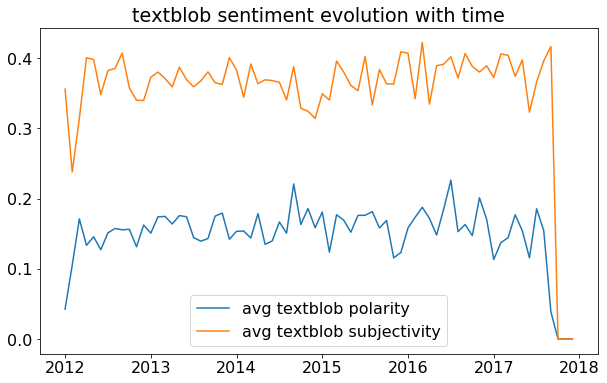

In [356]:
textblob_label = ['polarity', 'subjectivity']
fig, ax = plt.subplots(figsize = (10,6))
for i in range(2):
    vec = textblob_sentiment_by_month_avg[:,:,i].reshape(-1)
    plt.plot(vec, label = 'avg textblob '+ textblob_label[i])


ax.set_xticks(np.linspace(0,12*6,7))
ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
plt.title('textblob sentiment evolution with time')
plt.legend()
plt.show()

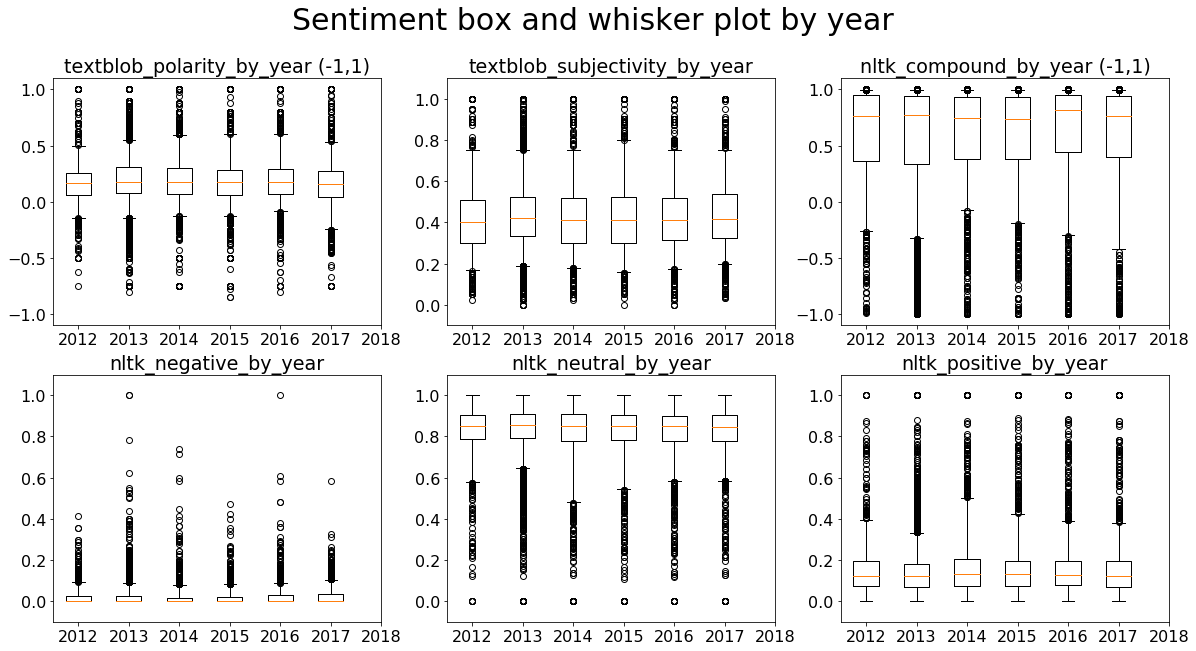

In [357]:
data_by_year = [textblob_polarity_by_year, textblob_subjectivity_by_year, nltk_compound_by_year, nltk_negative_by_year, nltk_neutral_by_year, nltk_positive_by_year]
labels = ['textblob_polarity_by_year (-1,1)', 'textblob_subjectivity_by_year', 'nltk_compound_by_year (-1,1)', 'nltk_negative_by_year', 'nltk_neutral_by_year', 'nltk_positive_by_year']
plt.figure(figsize =(20, 10)) 
plt.suptitle('Sentiment box and whisker plot by year', fontsize =30)
for i in range(6):# num of plots
    plt.subplot(2,3,i+1)
    ax = plt.gca()
    data = data_by_year[i]
    
#     mean = np.zeros(6) # num of year
#     std = np.zeros(6) # num of year
#     for j in range(6):
#         mean[j] = np.mean(data[j])
#         std[j] = np.std(data[j])
#     plt.errorbar(np.linspace(1,6,6), mean, std, fmt='-o')
    plt.boxplot(data, whis=(5,95)) 
    
    if i == 0 or i == 2:
        plt.ylim(-1.1,1.1)
    else:
        plt.ylim(-0.1,1.1)
    ax.set_xticks(np.linspace(1,7,7))
    ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
    plt.title(labels[i])
plt.show() 

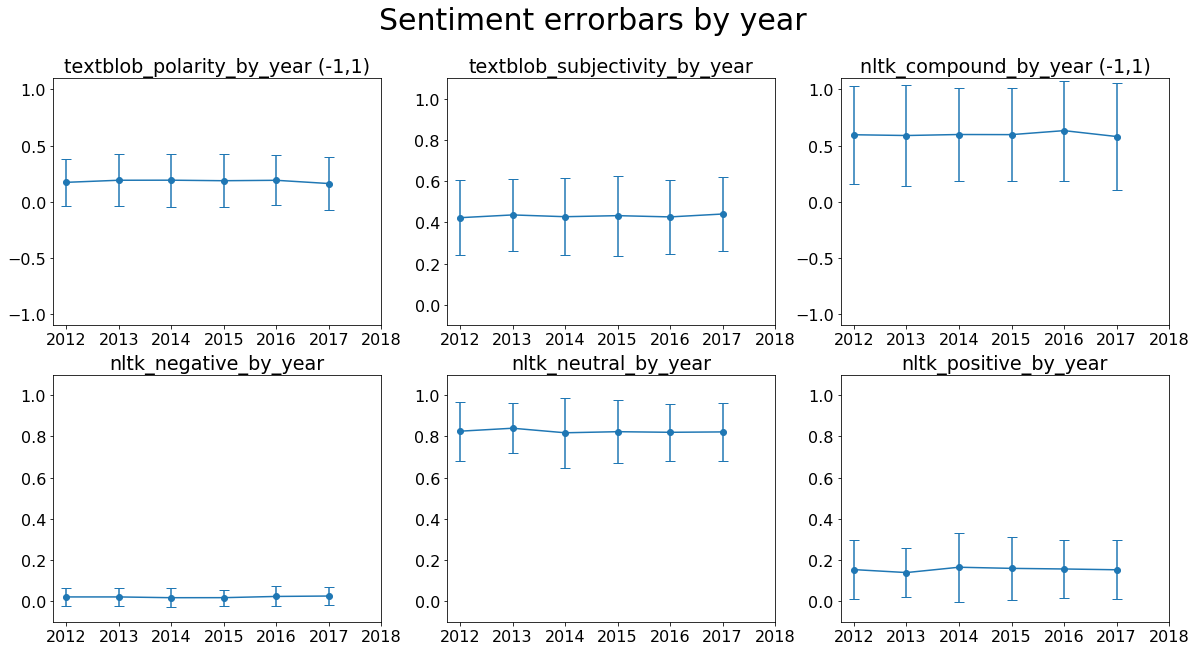

In [358]:
data_by_year = [textblob_polarity_by_year, textblob_subjectivity_by_year, nltk_compound_by_year, nltk_negative_by_year, nltk_neutral_by_year, nltk_positive_by_year]
labels = ['textblob_polarity_by_year (-1,1)', 'textblob_subjectivity_by_year', 'nltk_compound_by_year (-1,1)', 'nltk_negative_by_year', 'nltk_neutral_by_year', 'nltk_positive_by_year']
plt.figure(figsize =(20, 10)) 
plt.suptitle('Sentiment errorbars by year', fontsize =30)
for i in range(6):# num of plots
    plt.subplot(2,3,i+1)
    ax = plt.gca()
    data = data_by_year[i]
    
    mean = np.zeros(6) # num of year
    std = np.zeros(6) # num of year
    for j in range(6):
        mean[j] = np.mean(data[j])
        std[j] = np.std(data[j])
    plt.errorbar(np.linspace(1,6,6), mean, std, capsize=5, fmt='-o')
#     plt.boxplot(data, whis=(5,95)) 

    if i == 0 or i == 2:
        plt.ylim(-1.1,1.1)
    else:
        plt.ylim(-0.1,1.1)
    ax.set_xticks(np.linspace(1,7,7))
    ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
    plt.title(labels[i])
plt.show() 

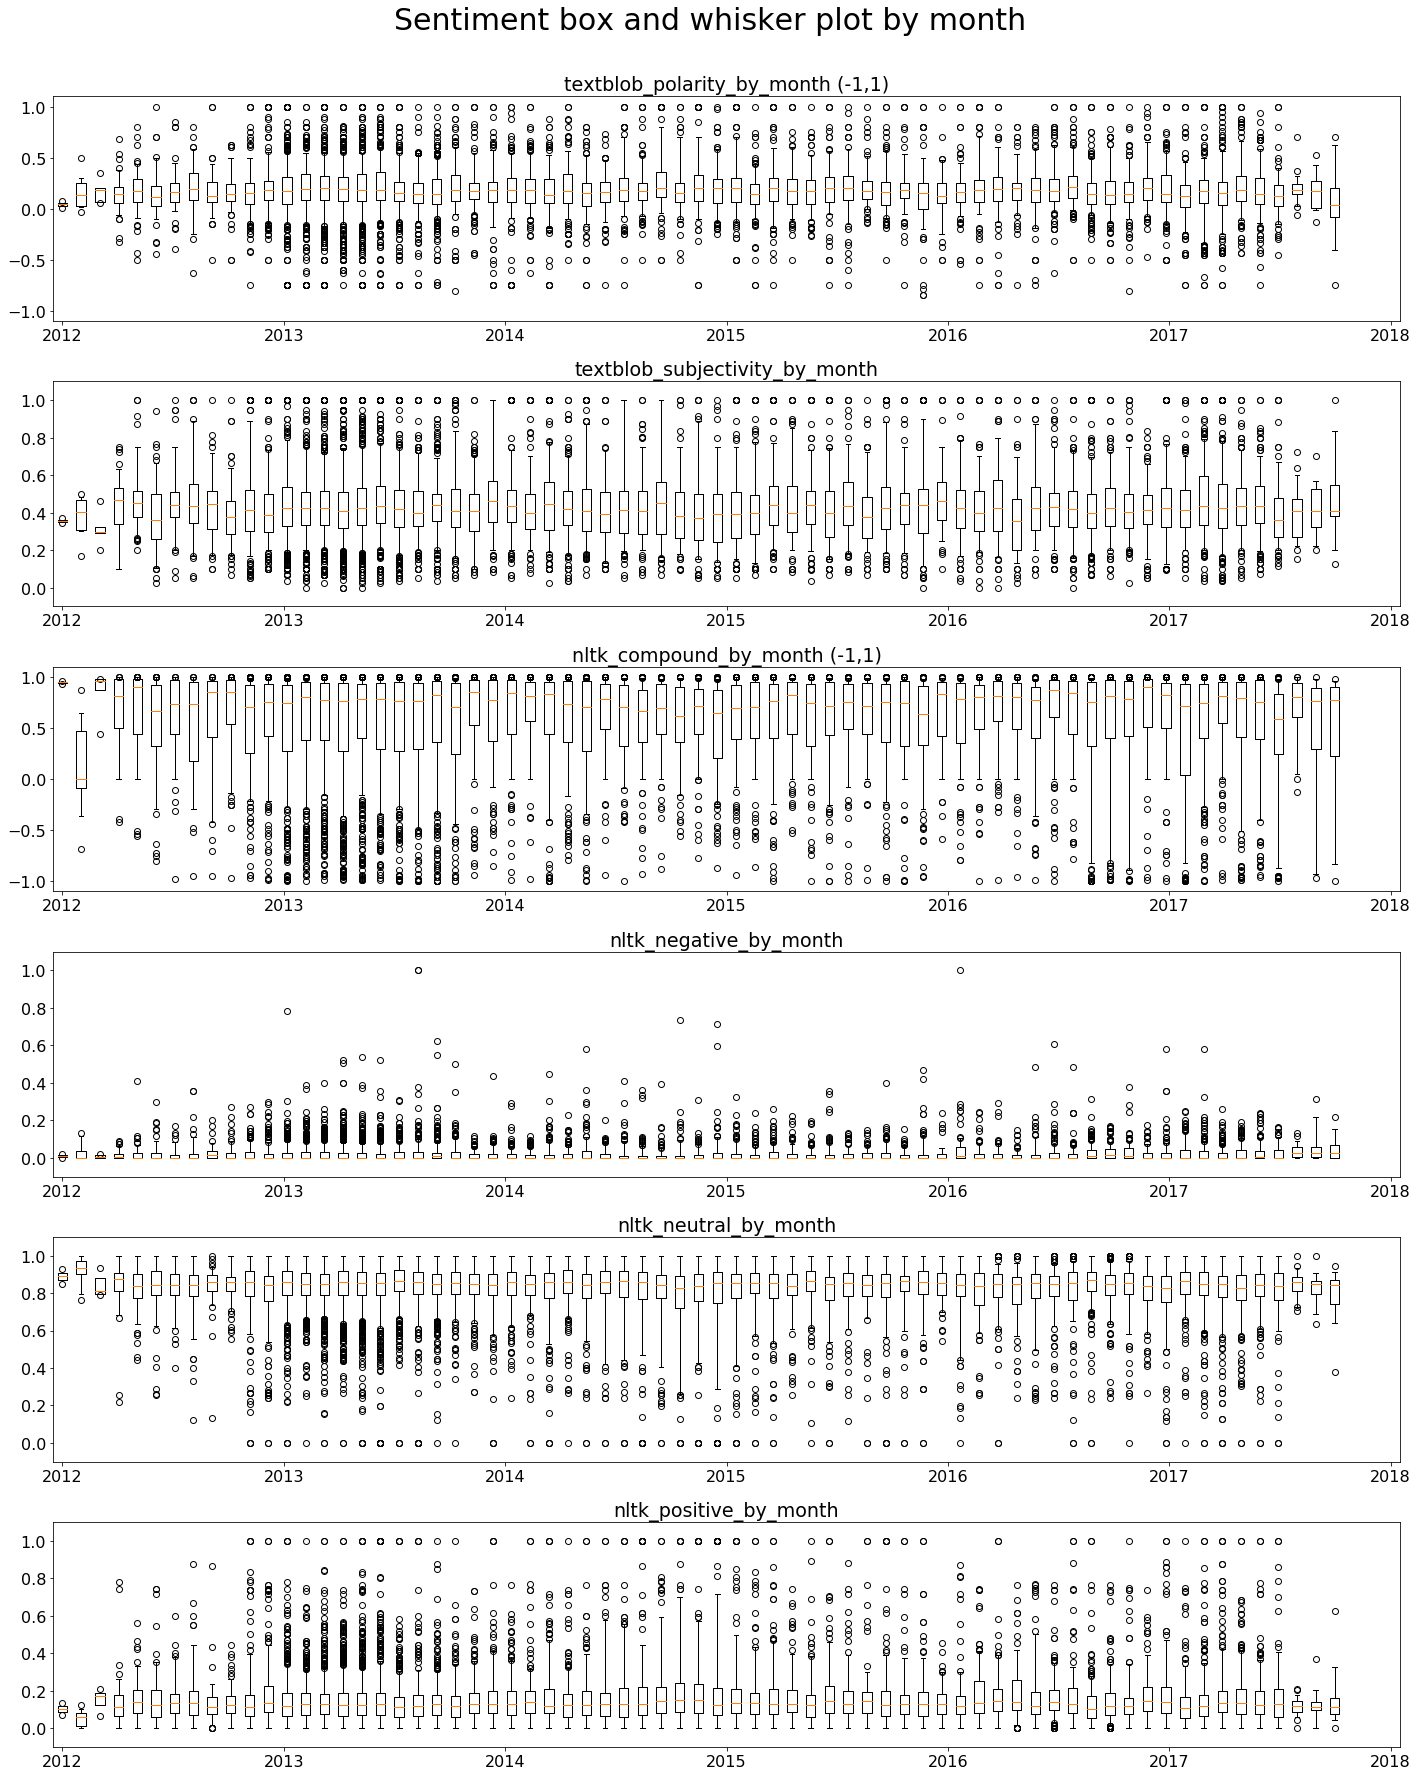

In [359]:
data_by_month = [textblob_polarity_by_month, textblob_subjectivity_by_month, nltk_compound_by_month, nltk_negative_by_month, nltk_neutral_by_month, nltk_positive_by_month]
labels = ['textblob_polarity_by_month (-1,1)', 'textblob_subjectivity_by_month', 'nltk_compound_by_month (-1,1)', 'nltk_negative_by_month', 'nltk_neutral_by_month', 'nltk_positive_by_month']
plt.figure(figsize =(20, 24)) 
plt.suptitle('Sentiment box and whisker plot by month', fontsize =30, y = 1.03)
for i in range(6):# num of plots
    plt.subplot(6,1,i+1)
    ax = plt.gca()
    data = data_by_month[i]
    
#     mean = np.zeros(6) # num of year
#     std = np.zeros(6) # num of year
#     for j in range(6):
#         mean[j] = np.mean(data[j])
#         std[j] = np.std(data[j])
#     plt.errorbar(np.linspace(1,6,6), mean, std, fmt='-o')
    plt.boxplot(data, whis=(5,95)) 
    
    if i == 0 or i == 2:
        plt.ylim(-1.1,1.1)
    else:
        plt.ylim(-0.1,1.1)
    ax.set_xticks(np.linspace(1,6*12,7))
    ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
    plt.title(labels[i])
plt.tight_layout()
plt.show() 



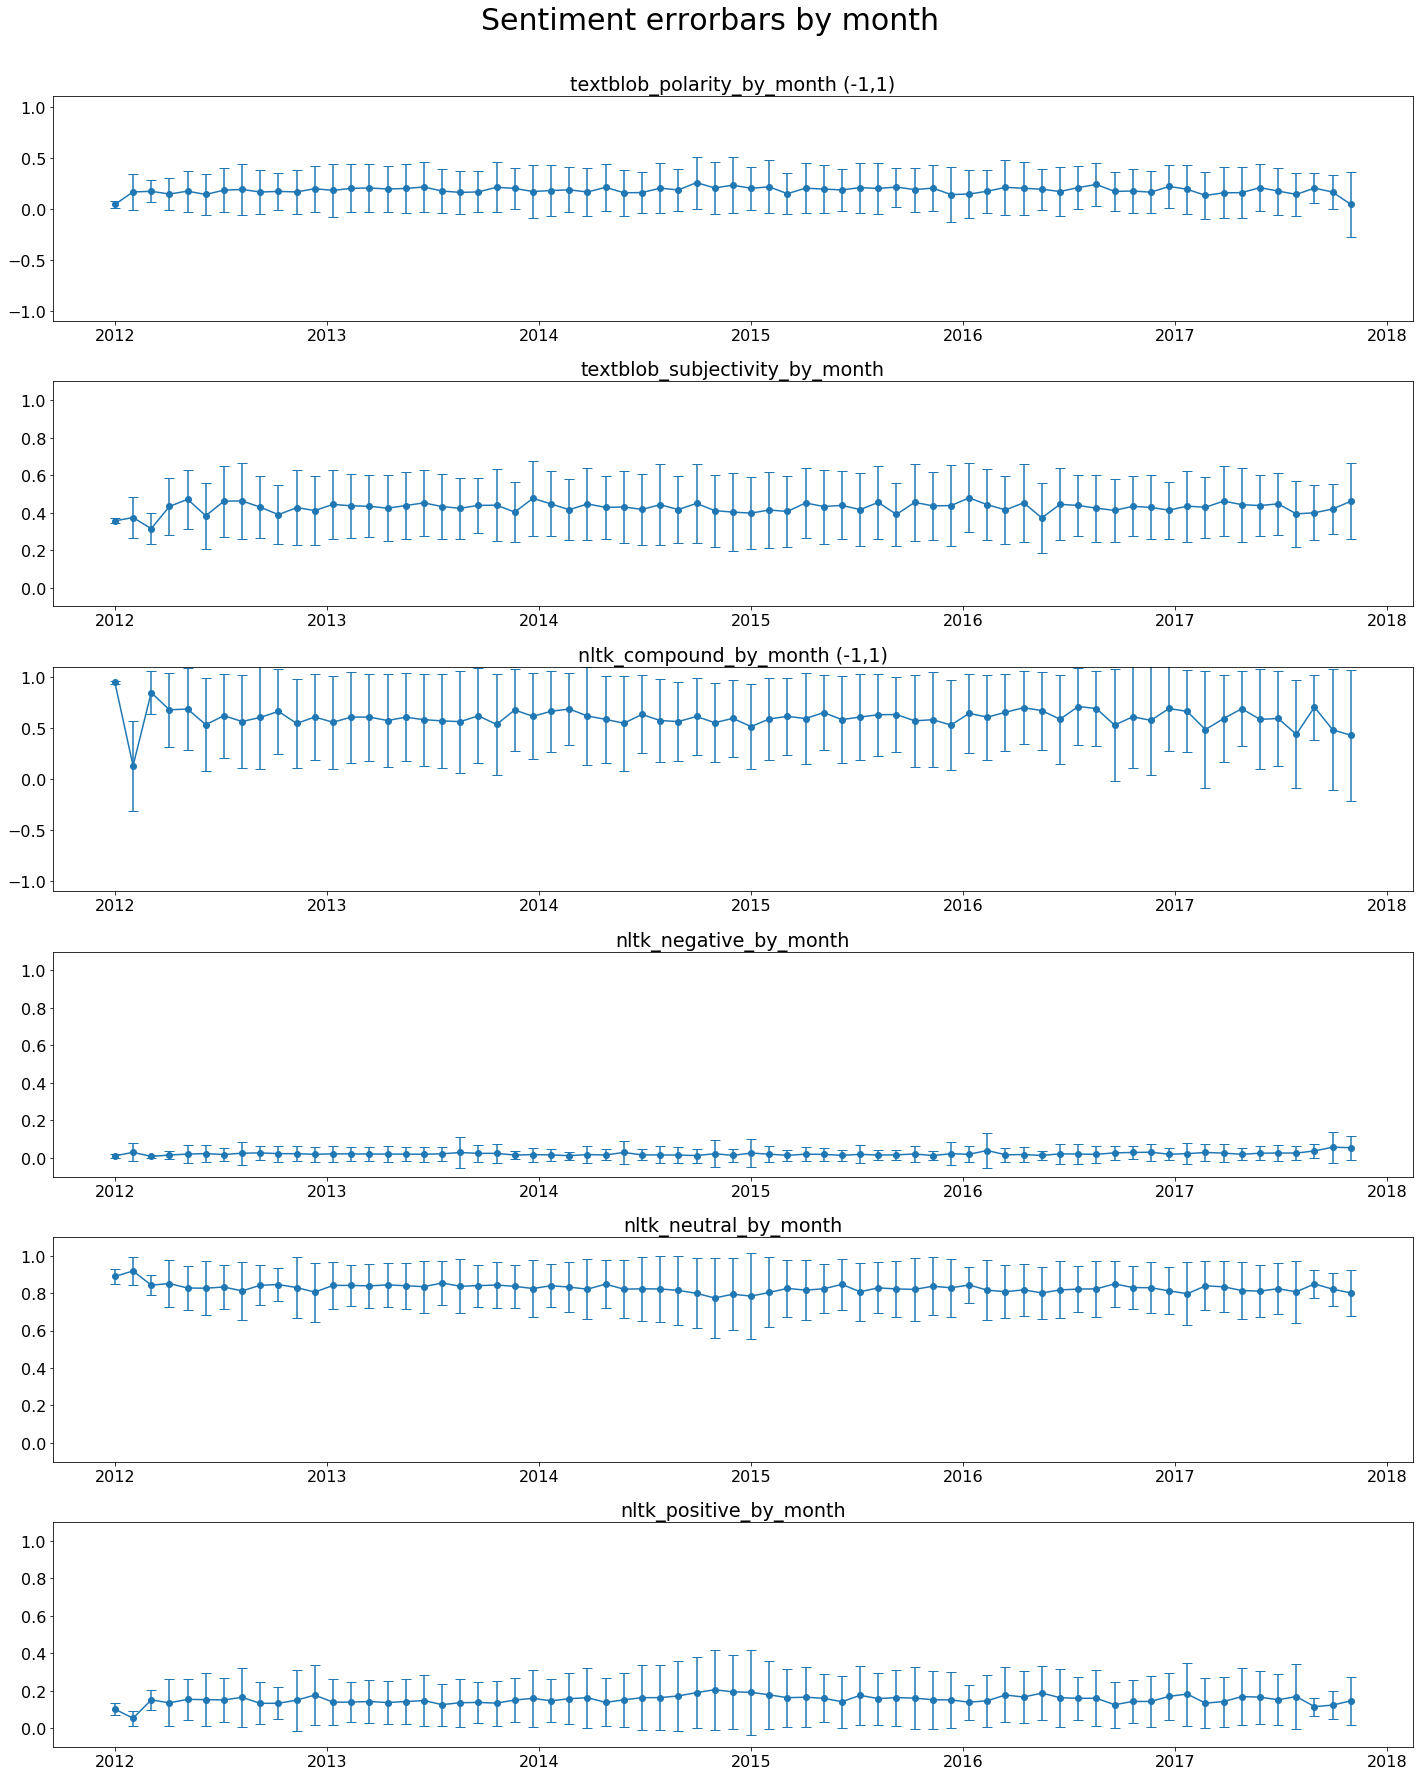

In [360]:
data_by_month = [textblob_polarity_by_month, textblob_subjectivity_by_month, nltk_compound_by_month, nltk_negative_by_month, nltk_neutral_by_month, nltk_positive_by_month]
labels = ['textblob_polarity_by_month (-1,1)', 'textblob_subjectivity_by_month', 'nltk_compound_by_month (-1,1)', 'nltk_negative_by_month', 'nltk_neutral_by_month', 'nltk_positive_by_month']
plt.figure(figsize =(20, 24)) 
plt.suptitle('Sentiment errorbars by month', fontsize =30, y = 1.03)
for i in range(6):# num of plots
    plt.subplot(6,1,i+1)
    ax = plt.gca()
    data = data_by_month[i]
    mean = np.zeros(len(data)) # num of month
    std = np.zeros(len(data)) # num of month
    for j in range(len(data)):
        mean[j] = np.mean(data[j])
        std[j] = np.std(data[j])
    plt.errorbar(np.linspace(1,len(data)+1,len(data)), mean, std, capsize=5, fmt='-o')
#     plt.boxplot(data, whis=(5,95)) 
    
    if i == 0 or i == 2:
        plt.ylim(-1.1,1.1)
    else:
        plt.ylim(-0.1,1.1)
    ax.set_xticks(np.linspace(1,6*12,7))
    ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
    plt.title(labels[i])
plt.tight_layout()
plt.show() 



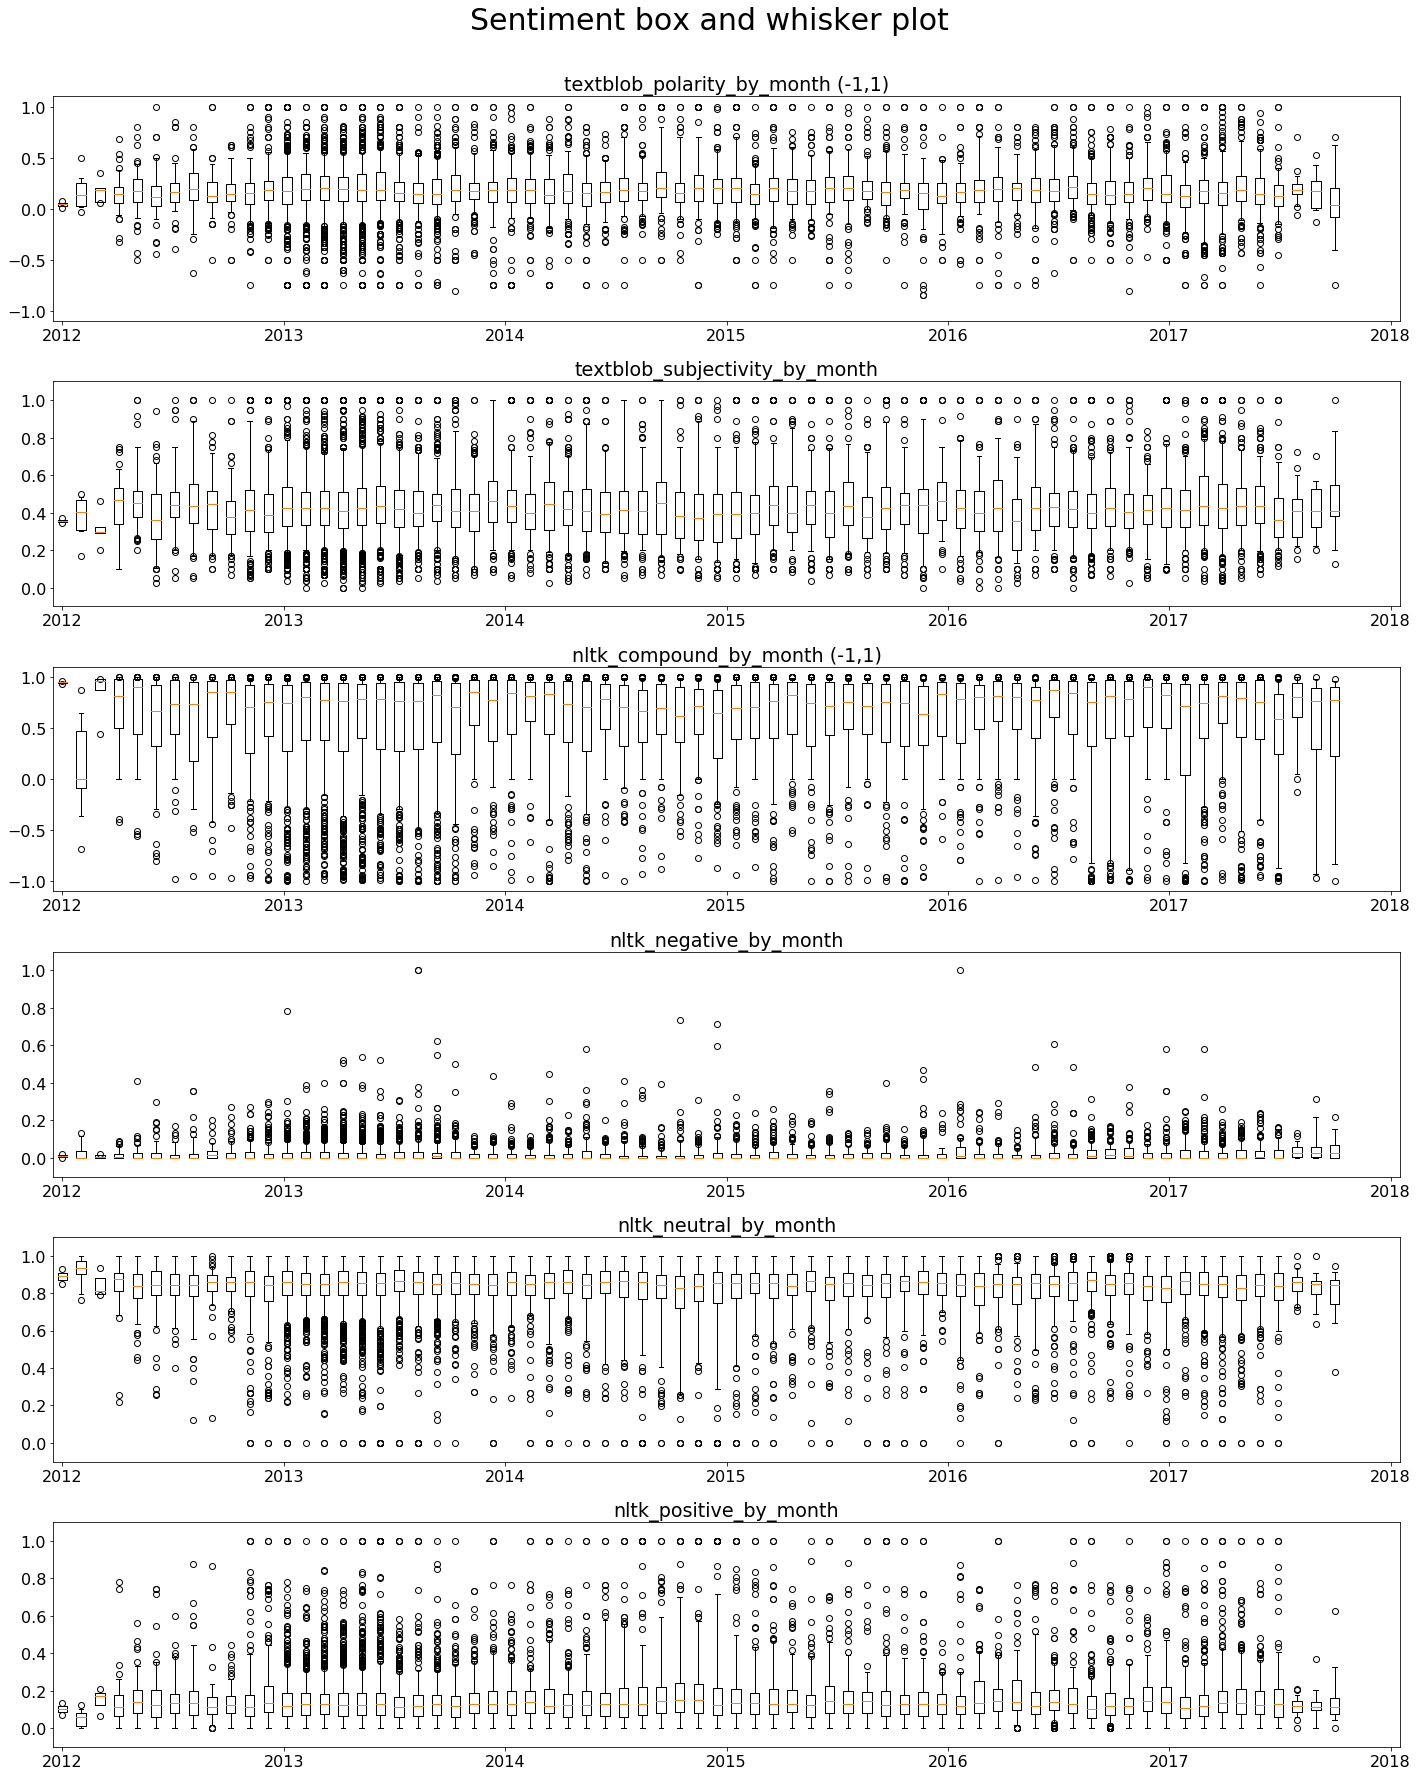

In [361]:
data_by_month = [textblob_polarity_by_month, textblob_subjectivity_by_month, nltk_compound_by_month, nltk_negative_by_month, nltk_neutral_by_month, nltk_positive_by_month]
labels = ['textblob_polarity_by_month (-1,1)', 'textblob_subjectivity_by_month', 'nltk_compound_by_month (-1,1)', 'nltk_negative_by_month', 'nltk_neutral_by_month', 'nltk_positive_by_month']
plt.figure(figsize =(20, 24)) 
plt.suptitle('Sentiment box and whisker plot', fontsize =30, y = 1.03)
for i in range(6):# num of plots
    plt.subplot(6,1,i+1)
    ax = plt.gca()
    data = data_by_month[i]
#     mean = np.zeros(len(data)) # num of month
#     std = np.zeros(len(data)) # num of month
#     for j in range(len(data)):
#         mean[j] = np.mean(data[j])
#         std[j] = np.std(data[j])
#     plt.errorbar(np.linspace(1,len(data)+1,len(data)), mean, std, capsize=5, fmt='-o')
    plt.boxplot(data, whis=(5,95)) 
    
    if i == 0 or i == 2:
        plt.ylim(-1.1,1.1)
    else:
        plt.ylim(-0.1,1.1)
    ax.set_xticks(np.linspace(1,6*12,7))
    ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
    plt.title(labels[i])
plt.tight_layout()
plt.show() 



In [362]:
# test

# fig, ax = plt.subplots(figsize =(20, 4)) 
# plt.boxplot(textblob_polarity_by_month) 
# vec = textblob_sentiment_by_month_avg[:,:,0].reshape(-1)
# plt.plot(np.linspace(1,12*6+1,12*6),vec)
# ax.set_xticks(np.linspace(0,12*6,7))
# ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
# plt.ylim(-0.1,1.1)
# plt.title('textblob polarity by month')
# plt.show() 

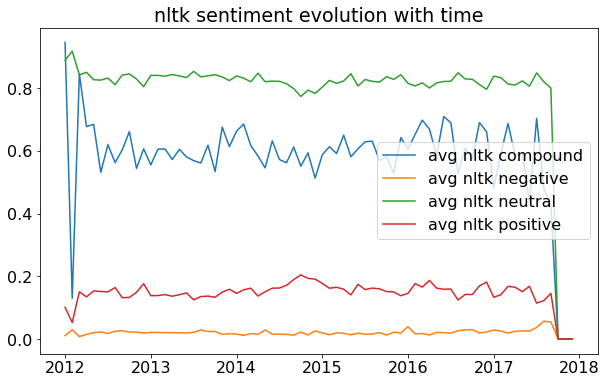

In [363]:
nltk_label = ['compound', 'negative', 'neutral', 'positive']
fig, ax = plt.subplots(figsize = (10,6))
for i in range(4):
    vec = nltk_sentiment_by_month_avg[:,:,i].reshape(-1)
    plt.plot(vec, label = 'avg nltk '+ nltk_label[i])
plt.title('nltk sentiment evolution with time')
ax.set_xticks(np.linspace(0,12*6,7))
ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
plt.legend()
plt.show()

# Senders' Sentiment

In [301]:
# adam corey

In [376]:
from_list = df['From'].values.tolist()
adam_corey_email_idxs = []
unique_email_address = []
adam_corey_email = []
for i in range(len(from_list)):
    from_list[i] = eval(from_list[i])
    if from_list[i][0] == 'adam' and from_list[i][1] == 'corey':
        email = from_list[i][2]
        adam_corey_email_idxs.append(i)
        if email in unique_email_address:
            adam_corey_email.append(unique_email_address.index(email))
        else:
            unique_email_address.append(email)
            adam_corey_email.append(unique_email_address.index(email))
            

In [303]:
unique_email_address
# 1 -> 0
# 5 -> 4
# 2 -> 4

['acorey@gunster.com',
 'mailtozacorey@gunster.com',
 'adam@101tallahassee.com',
 'adambcorey@gmail.com',
 'acorey@101tally.com',
 'mailtozacorey@101tally.com',
 'adam@unconventionalstrategies.com',
 'adam@edisontally.com']

In [304]:
import scipy.stats

In [305]:
adam_corey_textblob_sentiment = textblob_sentiment[adam_corey_email_idxs,:]

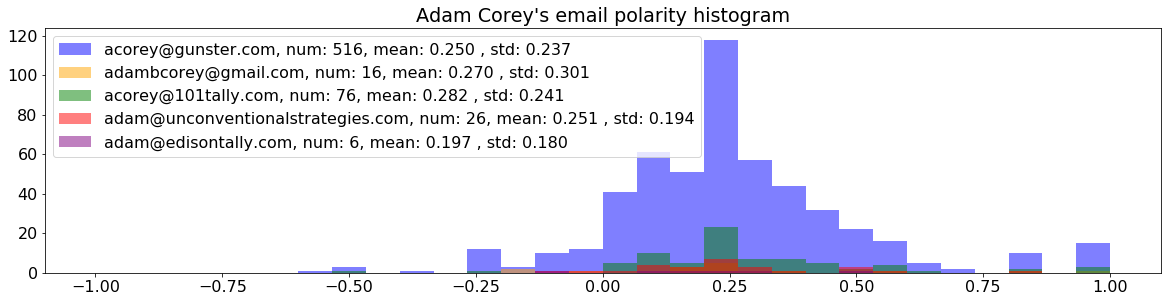

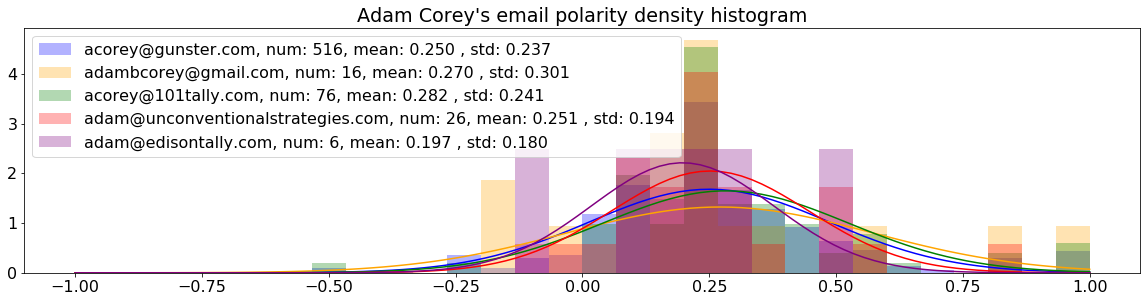

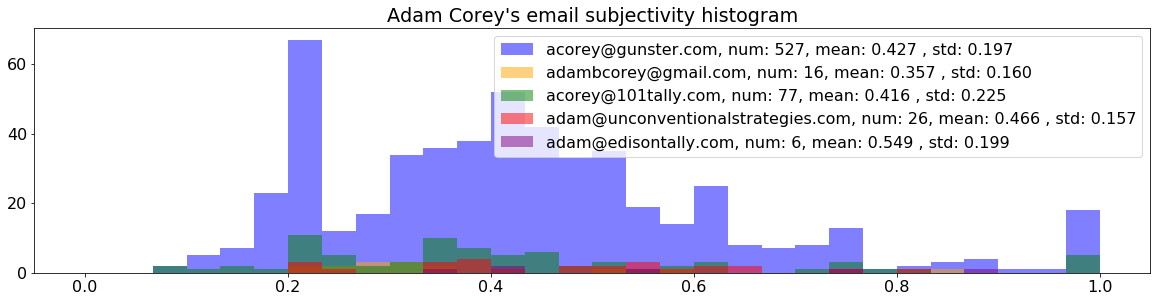

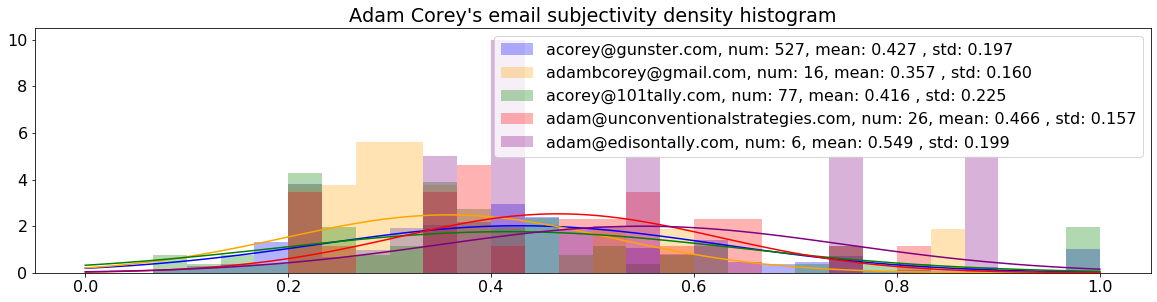

In [306]:
adam_corey_email = np.array(adam_corey_email)
adam_corey_email[adam_corey_email == 1] = 0
adam_corey_email[adam_corey_email == 5] = 4
adam_corey_email[adam_corey_email == 2] = 4

colors = ['blue','','','orange','green','','red','purple']
plt.figure(figsize=(20,4.5))
plt.title("Adam Corey's email polarity histogram")
for i in [0,3,4,6,7]:
    email_address = unique_email_address[i]
    vec = adam_corey_textblob_sentiment[adam_corey_email == i,0]
    vec = vec[vec!=0]
    num = len(vec)
    std = np.std(vec)
    mean = np.mean(vec)
    
#     fitted_x = np.linspace(-1,1,100)
#     fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, std)
#     scale = len(vec)*2/30
#     plt.plot(fitted_x,fitted_y * scale, color=colors[i])
    plt.hist(vec,density=False, range=[-1,1], bins=30, alpha = 0.5, label = email_address+ ', num: '+str(num)+', mean: '+ str(mean)[:5]+' , std: '+str(std)[:5], color=colors[i])
plt.legend()
plt.show()

plt.figure(figsize=(20,4.5))
plt.title("Adam Corey's email polarity density histogram")
for i in [0,3,4,6,7]:
    email_address = unique_email_address[i]
    vec = adam_corey_textblob_sentiment[adam_corey_email == i,0]
    vec = vec[vec!=0]
    num = len(vec)
    mean, var  = scipy.stats.distributions.norm.fit(vec)
    plt.hist(vec, density=True, range=[-1,1], bins=30, alpha = 0.3, label = email_address+ ', num: '+str(num)+ ', mean: '+ str(mean)[:5]+' , std: '+str(var)[:5], color=colors[i])
    fitted_x = np.linspace(-1,1,100)
    fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, var)
    plt.plot(fitted_x,fitted_y, color=colors[i])
plt.legend()
plt.show()

plt.figure(figsize=(20,4.5))
plt.title("Adam Corey's email subjectivity histogram")
for i in [0,3,4,6,7]:
    email_address = unique_email_address[i]
    vec = adam_corey_textblob_sentiment[adam_corey_email == i,1]
    vec = vec[vec!=0]
    num = len(vec)
    std = np.std(vec)
    mean = np.mean(vec)
    
#     fitted_x = np.linspace(-1,1,100)
#     fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, std)
#     scale = len(vec)*2/30
#     plt.plot(fitted_x,fitted_y * scale, color=colors[i])
    plt.hist(vec, density=False, range=[0,1], bins=30, alpha = 0.5, label = email_address+ ', num: '+str(num)+ ', mean: '+ str(mean)[:5]+' , std: '+str(std)[:5], color=colors[i])
plt.legend()
plt.show()

plt.figure(figsize=(20,4.5))
plt.title("Adam Corey's email subjectivity density histogram")
for i in [0,3,4,6,7]:
    email_address = unique_email_address[i]
    vec = adam_corey_textblob_sentiment[adam_corey_email == i,1]
    vec = vec[vec!=0]
    num = len(vec)
    mean, var  = scipy.stats.distributions.norm.fit(vec)
    plt.hist(vec, density=True, range=[0,1], bins=30, alpha = 0.3, label = email_address+ ', num: '+str(num)+ ', mean: '+ str(mean)[:5]+' , std: '+str(var)[:5], color=colors[i])
    fitted_x = np.linspace(0,1,100)
    fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, var)
    plt.plot(fitted_x,fitted_y, color=colors[i])
plt.legend()
plt.show()

In [380]:
# personal nltk sentiment evolution 
adam_corey_all_email_idxs = []
for i in range(len(from_list)):
    if from_list[i][0] == 'adam' and from_list[i][1] == 'corey':
        adam_corey_all_email_idxs.append(i)
df_adam = df.iloc[adam_corey_all_email_idxs]
df_adam = df_adam.reset_index(drop = True)
adam_year_list = df_adam['Sent'].dt.year
adam_month_list = df_adam['Sent'].dt.month

In [415]:

adam_textblob_polarity_by_month = []
adam_textblob_subjectivity_by_month = []

adam_nltk_compound_by_month = []
adam_nltk_negative_by_month = []
adam_nltk_neutral_by_month = []
adam_nltk_positive_by_month = []

adam_textblob_sentiment = np.array(textblob_sentiment)[adam_corey_all_email_idxs]

for i in range(6):
    for j in range(12):
        adam_textblob_polarity_by_month.append([])
        adam_textblob_subjectivity_by_month.append([])
#         adam_nltk_compound_by_month.append([])
#         adam_nltk_negative_by_month.append([])
#         adam_nltk_neutral_by_month.append([])
#         adam_nltk_positive_by_month.append([])   
        
for i in range(len(adam_year_list)):
    year_idx = adam_year_list[i]-2012
    month_idx = year_idx*12 + (adam_month_list[i]-1)
    if year_idx >= 7:
        continue
    if adam_textblob_sentiment[i,0] != 0 or adam_textblob_sentiment[i,1] != 0:

        adam_textblob_polarity_by_month[month_idx].append(adam_textblob_sentiment[i,0])
        adam_textblob_subjectivity_by_month[month_idx].append(adam_textblob_sentiment[i,1])
    
#     if adam_nltk_sentiment[i,1] != 0 or adam_nltk_sentiment[i,2] != 0 or adam_nltk_sentiment[i,3] != 0:
#         adam_nltk_compound_by_year[year_idx].append(nltk_sentiment[i,0])
#         adam_nltk_negative_by_year[year_idx].append(nltk_sentiment[i,1])
#         adam_nltk_neutral_by_year[year_idx].append(nltk_sentiment[i,2])
#         adam_nltk_positive_by_year[year_idx].append(nltk_sentiment[i,3])
#         adam_nltk_compound_by_month[month_idx].append(nltk_sentiment[i,0])
#         adam_nltk_negative_by_month[month_idx].append(nltk_sentiment[i,1])
#         adam_nltk_neutral_by_month[month_idx].append(nltk_sentiment[i,2])
#         adam_nltk_positive_by_month[month_idx].append(nltk_sentiment[i,3])


In [416]:
for i in range(12):
    suspect_email_idx = (adam_year_list==2015) * (adam_month_list == i)
    try:
        print(adam_textblob_sentiment[suspect_email_idx,0].max())
    except:
        pass
#     suspect_email_idx.sum()

1.0
0.43333333333333335
1.0
1.0
1.0
0.5666666666666667
0.8
1.0
0.5666666666666667
1.0
1.0


In [428]:
suspect_email_idx = (adam_year_list==2015) * (adam_month_list == 1)
np.sum(suspect_email_idx)

23

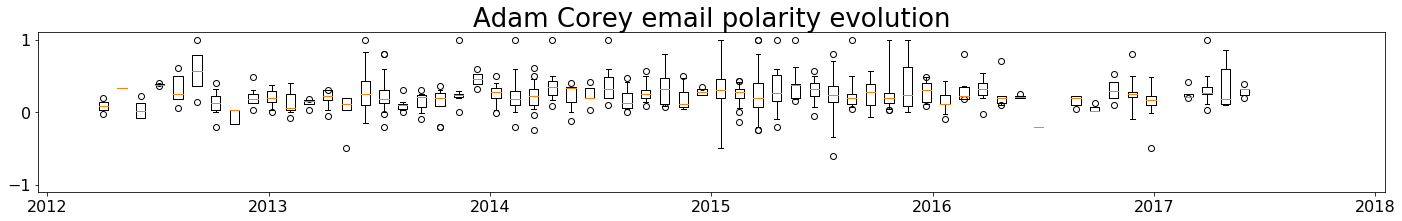

In [418]:
data = adam_textblob_polarity_by_month
plt.figure(figsize =(20, 3)) 
ax = plt.gca()
plt.boxplot(data, whis=(5,95)) 
plt.ylim(-1.1,1.1)
ax.set_xticks(np.linspace(1,6*12,7))
ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
plt.tight_layout()
plt.title('Adam Corey email polarity evolution', fontsize = 26)
plt.show() 

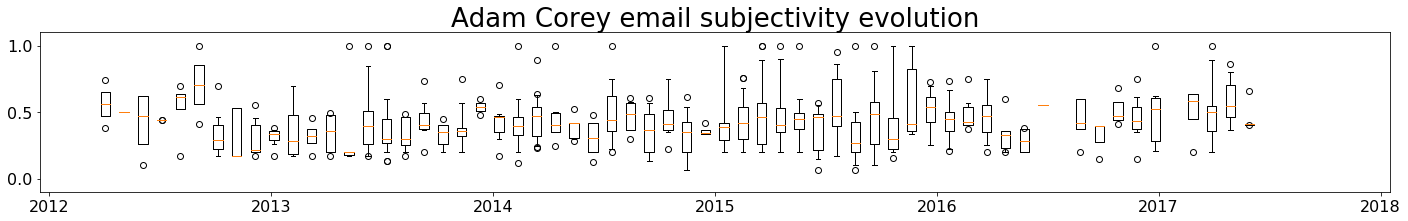

In [446]:
data = adam_textblob_subjectivity_by_month
plt.figure(figsize =(20, 3)) 
ax = plt.gca()
plt.boxplot(data, whis=(5,95)) 
plt.ylim(-0.1,1.1)
ax.set_xticks(np.linspace(1,6*12,7))
ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
plt.tight_layout()
plt.title('Adam Corey email subjectivity evolution', fontsize = 26)
plt.show() 

In [433]:
df_adam_suspect = df_adam[suspect_email_idx]
df_adam_suspect = df_adam_suspect.drop_duplicates(subset=['Sent'])
df_adam_suspect = df_adam_suspect.reset_index(drop=True)
df_adam_suspect

,From,Sent,To,CC,Subject,Attachments,Importance,Body,textblob_sentiment,nltk_sentiment
0,"('adam', 'corey', 'acorey@gunster.com')",2015-01-06 14:08:00,"[('phyllis', 'griffin', 'phyllis.griffin@talgo...","[('ryan', 'grindler', 'rgrindler@101tally.com')]",[],[],[],"['', 'Hi Phyllis. My business partner, Ryan Gr...","[0.0, 0.0]","[0.3612, 0.0, 0.923, 0.077]"
1,"('adam', 'corey', 'acorey@gunster.com')",2015-01-07 17:08:00,"[('jt', 'burnette', 'jt@inkbridge.com')]","[('phyllis', 'griffin', 'phyllis.griffin@talgo...",[],[],[],"['', 'Hi Phyllis,', 'The 12th and 19th are goo...","[0.44999999999999996, 0.4]","[0.8842, 0.0, 0.732, 0.268]"
2,"('adam', 'corey', 'acorey@gunster.com')",2015-01-09 10:36:00,"[('gmail', '', 'vilettaj@gmail.com')]","[('allie', 'behrman', 'allie_behrman')]",[],[],[],"['', 'Barry,', 'Im excited about this. Can we ...","[0.2746753246753247, 0.38901515151515154]","[0.977, 0.0, 0.808, 0.192]"
3,"('adam', 'corey', 'acorey@101tally.com')",2015-01-09 10:52:00,"[('allison', 'behrman', 'allison.behrman@talgo...","[('f20465', 'l20465', 'barry@georgeclinton.com...",[],[],[],"['', 'Of course. Tag away. This is going to be...","[0.3, 0.2]","[0.5106, 0.0, 0.883, 0.117]"
4,"('adam', 'corey', 'acorey@gunster.com')",2015-01-13 09:10:00,"[('favors thompson, anita', '', 'anita.favors....","[('dee', 'crumpler', 'willis.crumpler@talgov.c...",[],[],[],"['', 'Hi Anita,', 'I hope the New Year is trea...","[0.16885454545454548, 0.40378181818181813]","[0.9951, 0.009, 0.8, 0.191]"
5,"('adam', 'corey', 'acorey@gunster.com')",2015-01-13 16:05:00,"[('jessica', 'lowe', 'jessica_lowe'), ('nick',...",[],[],[],[],"['', 'Jessica and Nick,', '', 'It was nice see...","[0.4749999999999999, 0.6416666666666667]","[0.9348, 0.0, 0.752, 0.248]"
6,"('adam', 'corey', 'acorey@gunster.com')",2015-01-13 18:58:00,"[('angie', 'whitaker', 'angie.whitaker@talgov....",[],[],[],[],"['Chapter January 2015 Membership Meeting', ''...","[0.0, 0.0]","[0.3612, 0.0, 0.902, 0.098]"
7,"('adam', 'corey', 'acorey@gunster.com')",2015-01-15 11:32:00,"[('e', 'stevens', 'estevens@tallahasseeyellowc...","[('allison', 'behrman', 'allison.behrman@talgo...",[],[],[],"['', 'Beth,', 'Thanks for the update on Matt. ...","[0.2, 0.2]","[0.7269, 0.0, 0.887, 0.113]"
8,"('adam', 'corey', 'acorey@gunster.com')",2015-01-20 17:17:00,"[('ryan', 'grindler', 'rgrindler@101tally.com')]","[('dee', 'crumpler', 'willis.crumpler@talgov.c...",[],[],[],"['', 'Dee,', 'I just got your note below. Have...","[0.2, 0.2]","[0.6124, 0.0, 0.898, 0.102]"
9,"('adam', 'corey', 'acorey@gunster.com')",2015-01-21 12:26:00,"[('nancy', 'miller', 'nancy.miller@talgov.com')]",[],[],[],[],[''],"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"


In [436]:
for i in range(len(df_adam_suspect)):
    print('*'*25,'Adam', 'email NO.',i,' in suspicious time, polarity:',eval(df_adam_suspect['textblob_sentiment'][i])[0],'*'*25)
    print(df_adam_suspect.iloc[i]['Body'])

************************* Adam email NO. 0  in suspicious time, polarity: 0.0 *************************
['', 'Hi Phyllis. My business partner, Ryan Grindler, will be there on my behalf. Thank you.', 'Adam Corey', 'Owner', '101 Restaurant', '215 West College Avenue, 101', 'Tallahassee, FL 32301', '850-391-1309', 'acorey@101tally.com', 'www.101tally.com']
************************* Adam email NO. 1  in suspicious time, polarity: 0.44999999999999996 *************************
['', 'Hi Phyllis,', 'The 12th and 19th are good for me. Thanks so much, Adam Corey', 'On Wed, Jan 7, 2015 at 3:54 PM, JT Burnette <jt@inkbridge.com> wrote:', 'The 19th and 24th are good for me']
************************* Adam email NO. 2  in suspicious time, polarity: 0.2746753246753247 *************************
['', 'Barry,', 'Im excited about this. Can we plan for January 20th? What time and where?', 'Thanks so much,', 'Adam Corey', 'Owner', '101 Restaurant', '215 West College Avenue, 101', 'Tallahassee, FL 32301', '

In [ ]:
# adam gmail

In [369]:
adam_gmail_idx = []
for i in range(len(df)):
    if eval(df.iloc[i]['From'])[2] == 'adambcorey@gmail.com':
        adam_gmail_idx.append(i)

In [374]:
df_adam_gmail = df.iloc[adam_gmail_idx]
df_adam_gmail = df_adam_gmail.reset_index(drop=True)
for i in range(len(df_adam_gmail)):
    print('*'*25,'Adam to',df_adam_gmail.iloc[i]['To'], 'email NO.',i,'*'*25)
    print(df_adam_gmail.iloc[i]['Body'])

************************* Adam to [('ann', 'hunt', 'ann.hunt@talgov.com')] email NO. 0 *************************
['', 'Ann Marie,', 'Thank you for your email. January 23rd would be best for me. Should I plan to meet at the', 'airport?', 'Sherry, please add to my calendar.', 'Many thanks,', 'Adam Corey', 'Government Affairs', 'Gunster Law Firm', '215 South Monroe Street', 'Suite 601', 'Tallahassee, FL 32301', '850-521-1980', '', 'Adam Corey', 'Owner', '101 Restaurant', '215 West College Avenue', 'Suite 101', 'Tallahassee, FL 32301', '(850) 391-1309']
************************* Adam to [('ania', 'amador', 'ania_amador')] email NO. 1 *************************
['', 'Thanks Ania.', 'David,', 'Please pass along the 101 logo AND the Mint logo to all on this email.', '', 'Adam Corey', 'Government Affairs', 'Gunster Law inn', '', '215 South Monroe Street', 'Suite 601', '', 'Tallahassee, FL 32301', '850-521-1980', '', 'Adam Corey', '', 'Owner', '', '10 1 Restaurant', '', '215 West College Avenue'

In [307]:
# scott maddox

In [308]:
scott_maddox_email_idxs = []
unique_email_address = []
scott_maddox_email = []
for i in range(len(from_list)):
    if from_list[i][0] == 'scott' and from_list[i][1] == 'maddox':
        email = from_list[i][2]
        scott_maddox_email_idxs.append(i)
        if email in unique_email_address:
            scott_maddox_email.append(unique_email_address.index(email))
        else:
            unique_email_address.append(email)
            scott_maddox_email.append(unique_email_address.index(email))
            

In [309]:
unique_email_address

['scott.maddox@talgov.com',
 'scott@scottmaddox.com',
 'scottcharlesmaddox@gmail.com',
 'shamaddox@embarqmail.com']

In [310]:
scott_maddox_textblob_sentiment = textblob_sentiment[scott_maddox_email_idxs,:]

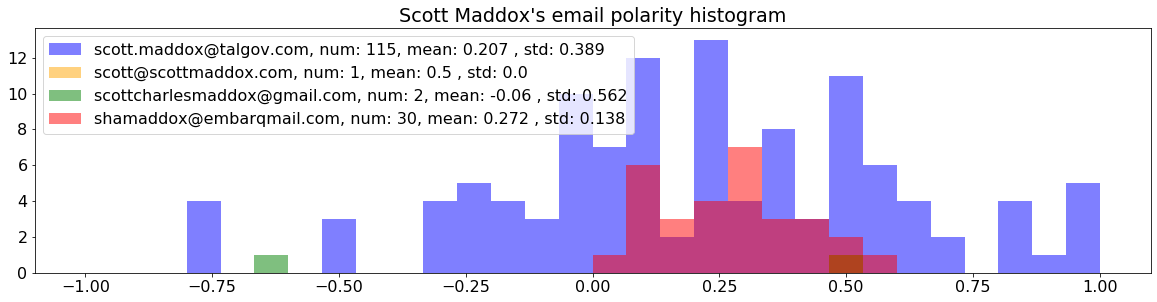

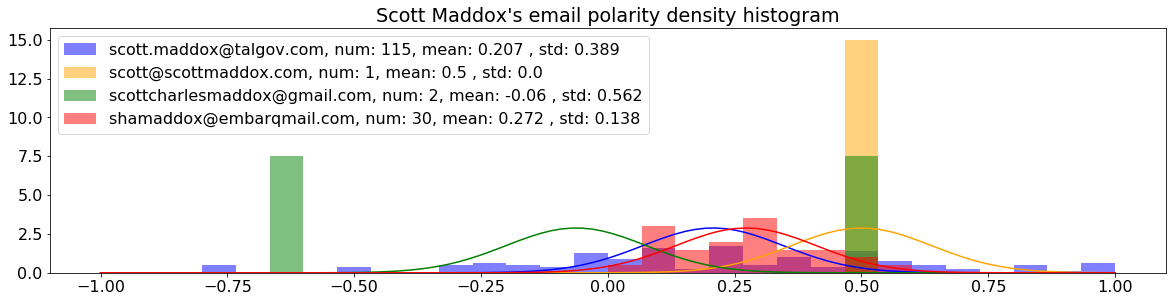

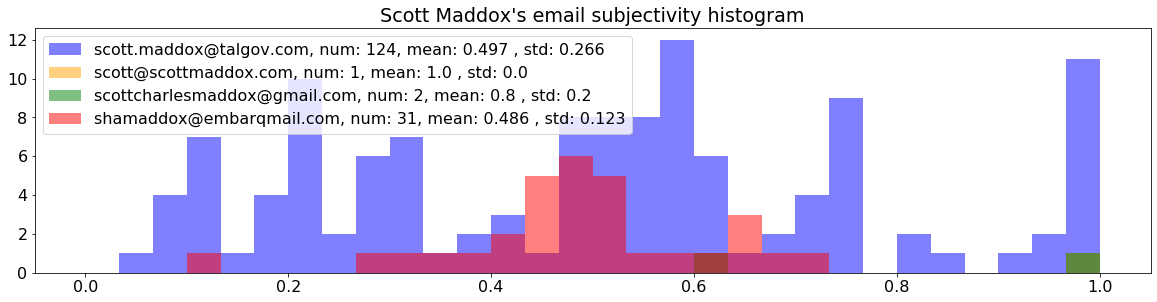

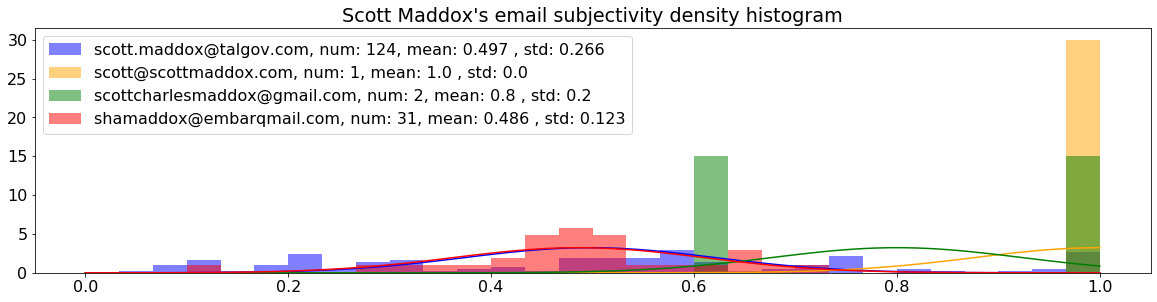

In [311]:
scott_maddox_email = np.array(scott_maddox_email)
# scott_maddox_email[scott_maddox_email == 1] = 0
# scott_maddox_email[scott_maddox_email == 5] = 4

colors = ['blue','orange','green','red']
plt.figure(figsize=(20,4.5))
plt.title("Scott Maddox's email polarity histogram")
for i in range(len(unique_email_address)):
    email_address = unique_email_address[i]
    vec = scott_maddox_textblob_sentiment[scott_maddox_email == i,0]
    vec = vec[vec!=0]
    std = np.std(vec)
    mean = np.mean(vec)
    num = len(vec)
#     mean, var  = scipy.stats.distributions.norm.fit(vec)
#     fitted_x = np.linspace(-1,1,100)
#     fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, std)
#     plt.plot(fitted_x,fitted_y, color=colors[i])
    plt.hist(vec,density=False, range=[-1,1], bins=30, alpha = 0.5, label = email_address+ ', num: '+str(num)+', mean: '+ str(mean)[:5]+' , std: '+str(std)[:5], color=colors[i])
plt.legend()
plt.show()

plt.figure(figsize=(20,4.5))
plt.title("Scott Maddox's email polarity density histogram")
for i in range(len(unique_email_address)):
    email_address = unique_email_address[i]
    vec = scott_maddox_textblob_sentiment[scott_maddox_email == i,0]
    vec = vec[vec!=0]
#     std = np.std(vec)
#     mean = np.mean(vec)
    num = len(vec)
    mean, var  = scipy.stats.distributions.norm.fit(vec)
    fitted_x = np.linspace(-1,1,100)
    fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, std)
    plt.plot(fitted_x,fitted_y, color=colors[i])
    plt.hist(vec,density=True, range=[-1,1], bins=30, alpha = 0.5, label = email_address+ ', num: '+str(num)+', mean: '+ str(mean)[:5]+' , std: '+str(var)[:5], color=colors[i])
plt.legend()
plt.show()

plt.figure(figsize=(20,4.5))
plt.title("Scott Maddox's email subjectivity histogram")
for i in range(len(unique_email_address)):
    email_address = unique_email_address[i]
    vec = scott_maddox_textblob_sentiment[scott_maddox_email == i,1]
    vec = vec[vec!=0]
    std = np.std(vec)
    mean = np.mean(vec)
    num = len(vec)
#     mean, var  = scipy.stats.distributions.norm.fit(vec)
#     fitted_x = np.linspace(-1,1,100)
#     fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, std)
#     plt.plot(fitted_x,fitted_y, color=colors[i])
    plt.hist(vec,density=False, range=[0,1], bins=30, alpha = 0.5, label = email_address+ ', num: '+str(num)+', mean: '+ str(mean)[:5]+' , std: '+str(std)[:5], color=colors[i])
plt.legend()
plt.show()

plt.figure(figsize=(20,4.5))
plt.title("Scott Maddox's email subjectivity density histogram")
for i in range(len(unique_email_address)):
    email_address = unique_email_address[i]
    vec = scott_maddox_textblob_sentiment[scott_maddox_email == i,1]
    vec = vec[vec!=0]
    num = len(vec)
    mean, var  = scipy.stats.distributions.norm.fit(vec)
    fitted_x = np.linspace(0,1,100)
    fitted_y = scipy.stats.distributions.norm.pdf(fitted_x, mean, std)
    plt.plot(fitted_x,fitted_y, color=colors[i])
    plt.hist(vec,density=True, range=[0,1], bins=30, alpha = 0.5, label = email_address+ ', num: '+str(num)+', mean: '+ str(mean)[:5]+' , std: '+str(var)[:5], color=colors[i])
plt.legend()
plt.show()

In [442]:
scott_maddox_all_email_idxs = []
for i in range(len(from_list)):
    if from_list[i][0] == 'scott' and from_list[i][1] == 'maddox':
        scott_maddox_all_email_idxs.append(i)
df_scott = df.iloc[scott_maddox_all_email_idxs]
df_scott = df_scott.reset_index(drop = True)
scott_year_list = df_scott['Sent'].dt.year
scott_month_list = df_scott['Sent'].dt.month
scott_textblob_polarity_by_month = []
scott_textblob_subjectivity_by_month = []

scott_nltk_compound_by_month = []
scott_nltk_negative_by_month = []
scott_nltk_neutral_by_month = []
scott_nltk_positive_by_month = []

scott_textblob_sentiment = np.array(textblob_sentiment)[scott_maddox_all_email_idxs]

for i in range(6):
    for j in range(12):
        scott_textblob_polarity_by_month.append([])
        scott_textblob_subjectivity_by_month.append([])
#         adam_nltk_compound_by_month.append([])
#         adam_nltk_negative_by_month.append([])
#         adam_nltk_neutral_by_month.append([])
#         adam_nltk_positive_by_month.append([])   
        
for i in range(len(scott_month_list)):
    year_idx = scott_year_list[i]-2012
    month_idx = year_idx*12 + (scott_month_list[i]-1)
    if year_idx >= 7:
        continue
    if scott_textblob_sentiment[i,0] != 0 or scott_textblob_sentiment[i,1] != 0:

        scott_textblob_polarity_by_month[month_idx].append(scott_textblob_sentiment[i,0])
        scott_textblob_subjectivity_by_month[month_idx].append(scott_textblob_sentiment[i,1])
    
#     if adam_nltk_sentiment[i,1] != 0 or adam_nltk_sentiment[i,2] != 0 or adam_nltk_sentiment[i,3] != 0:
#         adam_nltk_compound_by_year[year_idx].append(nltk_sentiment[i,0])
#         adam_nltk_negative_by_year[year_idx].append(nltk_sentiment[i,1])
#         adam_nltk_neutral_by_year[year_idx].append(nltk_sentiment[i,2])
#         adam_nltk_positive_by_year[year_idx].append(nltk_sentiment[i,3])
#         adam_nltk_compound_by_month[month_idx].append(nltk_sentiment[i,0])
#         adam_nltk_negative_by_month[month_idx].append(nltk_sentiment[i,1])
#         adam_nltk_neutral_by_month[month_idx].append(nltk_sentiment[i,2])
#         adam_nltk_positive_by_month[month_idx].append(nltk_sentiment[i,3])


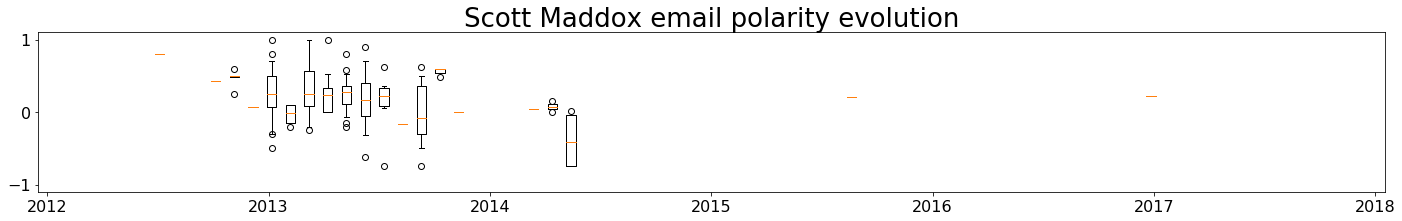

In [452]:
data = scott_textblob_polarity_by_month
plt.figure(figsize =(20, 3)) 
ax = plt.gca()
plt.boxplot(data, whis=(5,95)) 
plt.ylim(-1.1,1.1)
ax.set_xticks(np.linspace(1,6*12,7))
ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
plt.tight_layout()
plt.title('Scott Maddox email polarity evolution', fontsize = 26)
plt.show() 

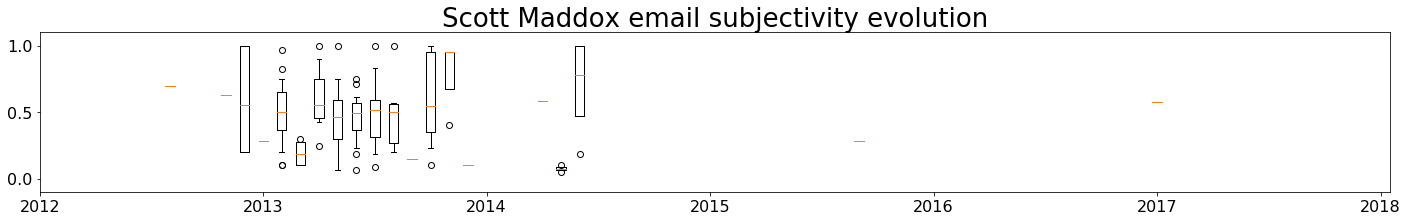

In [454]:
data = scott_textblob_subjectivity_by_month
plt.figure(figsize =(20, 3)) 
ax = plt.gca()
plt.boxplot(data, whis=(5,95)) 
plt.ylim(-0.1,1.1)
ax.set_xticks(np.linspace(0,6*12,7))
ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018'])
plt.tight_layout()
plt.title('Scott Maddox email subjectivity evolution', fontsize = 26)
plt.show() 

In [456]:
suspect_email_idx = (scott_year_list==2012) * (scott_month_list == i)
df_scott_suspect = df_scott[suspect_email_idx]
df_scott_suspect = df_scott_suspect.drop_duplicates(subset=['Sent'])
df_scott_suspect = df_scott_suspect.reset_index(drop=True)
df_scott_suspect

,From,Sent,To,CC,Subject,Attachments,Importance,Body,textblob_sentiment,nltk_sentiment
0,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-07 15:24:00,"[('angie', 'whitaker', 'angie.whitaker@talgov....","[('scott', 'maddox', 'maddox@maddoxhorne.com')...",[],[],[],"['', 'Thanks Ang!!! Rolling in greatness!']","[0.48828125, 0.2]","[0.6209, 0.0, 0.496, 0.504]"
1,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-26 14:27:00,"[('angela', 'hendrieth', 'angela.hendrieth@tal...",[],[],[],[],['Accepted: Save the Date - MLK Breakfast'],"[0.0, 0.0]","[0.6486, 0.0, 0.43, 0.57]"
2,"('scott', 'maddox', 'scott@scottmaddox.com')",2012-11-26 15:15:00,"[('lizzy', 'kelley', 'lizzy.kelley@talgov.com')]","[('scott', 'maddox', 'scott@scottmaddox.com'),...",[],[],[],['I can do if it helps.'],"[0.0, 0.0]","[0.3818, 0.0, 0.606, 0.394]"
3,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-26 15:44:00,"[('lizzy', 'kelley', 'lizzy.kelley@talgov.com')]","[('paige', 'carter-smith', 'paige@govinc.net')]",[],[],[],"['', 'Thanks Lizzy! Can you send the particula...","[0.25, 0.2]","[0.7494, 0.0, 0.556, 0.444]"
4,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-26 17:16:00,"[('scott', 'maddox', 'scott@scottmaddox.com')]",[],['Fwd: Address List'],['Address list.doc; ATT00001.htm'],[],[''],"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"
5,"('scott', 'maddox', 'scott@scottmaddox.com')",2012-11-27 18:20:00,"[('paige', 'carter-smith', 'paige@govinc.net')]","[('sandra', 'manning', 'sandra_manning'), ('sc...",[],[],[],"['', 'But if you just give me the talking poin...","[0.5, 1.0]","[-0.2732, 0.144, 0.778, 0.078]"
6,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-29 15:03:00,"[(""m'lisa"", 'ingram', 'mlisa.ingram@talgov.com')]",[],[],[],[],"['Re:', 'I nominate the mayor.']","[0.0, 0.0]","[0.0, 0.0, 1.0, 0.0]"
7,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-29 15:07:00,"[('scott', 'maddox', 'shamaddox@embarqmail.com')]",[],['Fwd: Invitation to Commissioner Scott Maddox...,[''],[],['Invitation to Commissioner Scott Maddox.pdf;...,"[0.0, 0.0]","[0.0, 0.0, 1.0, 0.0]"
8,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-30 14:54:00,"[('scott', 'maddox', 'scott@scottmaddox.com')]",[],['Fwd: Lighting Ceremony'],[''],[],['lighting ceremony timeline.docx; ATT00001.ht...,"[0.0, 0.0]","[0.0, 0.0, 1.0, 0.0]"
9,"('scott', 'maddox', 'scott.maddox@talgov.com')",2012-11-30 14:59:00,"[('james', 'thornber', 'james.thornber@talgov....",[],[],[],[],"['Re: Welcome back!', 'Thank you brother!!!!!!...","[0.6, 0.5499999999999999]","[0.8645, 0.0, 0.383, 0.617]"


In [462]:
for i in range(len(df_scott_suspect)):
    print('*'*15,'Scott to',df_scott_suspect.iloc[i]['To'], 'email NO.',i,'sentiment:',eval(df_scott_suspect.iloc[i]['textblob_sentiment'])[0],'*'*15)
    print(df_scott_suspect.iloc[i]['Body'])

*************** Scott to [('angie', 'whitaker', 'angie.whitaker@talgov.com')] email NO. 0 sentiment: 0.48828125 ***************
['', 'Thanks Ang!!! Rolling in greatness!']
*************** Scott to [('angela', 'hendrieth', 'angela.hendrieth@talgov.com')] email NO. 1 sentiment: 0.0 ***************
['Accepted: Save the Date - MLK Breakfast']
*************** Scott to [('lizzy', 'kelley', 'lizzy.kelley@talgov.com')] email NO. 2 sentiment: 0.0 ***************
['I can do if it helps.']
*************** Scott to [('lizzy', 'kelley', 'lizzy.kelley@talgov.com')] email NO. 3 sentiment: 0.25 ***************
['', 'Thanks Lizzy! Can you send the particulars to paige@govinc.net? Thanks!']
*************** Scott to [('scott', 'maddox', 'scott@scottmaddox.com')] email NO. 4 sentiment: 0.0 ***************
['']
*************** Scott to [('paige', 'carter-smith', 'paige@govinc.net')] email NO. 5 sentiment: 0.5 ***************
['', 'But if you just give me the talking point you want stressed I can handle :).

In [458]:
scott_gmail_idx = []
for i in range(len(df)):
    if eval(df.iloc[i]['From'])[2] == 'scottcharlesmaddox@gmail.com':
        scott_gmail_idx.append(i)

In [463]:
df_scott_gmail = df.iloc[scott_gmail_idx]
df_scott_gmail = df_scott_gmail.reset_index(drop=True)
for i in range(len(df_scott_gmail)):
    print('*'*15,'Scott to',df_scott_gmail.iloc[i]['To'], 'email NO.',i,'sentiment:',eval(df_scott_gmail.iloc[i]['textblob_sentiment'])[0],'*'*15)
    print(df_scott_gmail.iloc[i]['Body'])

*************** Scott to [('cassandra', 'jackson', 'cassandra.jackson@talgov.com')] email NO. 0 sentiment: 0.0 ***************
['', 'CassandraBased on the attached- what could I start this person at?', 'ThanksScott']
*************** Scott to [('scott', 'maddox', 'scott@scottmaddox.com'), ('scott', 'maddox', 'scott.maddox@talgov.com')] email NO. 1 sentiment: 0.0 ***************
['Maddox BioShot.jpg']
*************** Scott to [('scott', 'maddox', 'shamaddox@embarqmail.com'), ('allie', 'fleming', 'amerzerfleming@yahoo.com')] email NO. 2 sentiment: 0.0 ***************
['']
*************** Scott to [('allie', 'fleming', 'amerzerfleming@yahoo.com')] email NO. 3 sentiment: 0.0 ***************
['Re: PSA: pls review ASAP so I can send to charlie/etc', 'Way over thirty seconds', '']
*************** Scott to [('allie', 'fleming', 'amerzerfleming@yahoo.com')] email NO. 4 sentiment: 0.0 ***************
['Re: From Comm Maddox for review', 'Got it. Ty']
*************** Scott to [('scott', 'maddox', '

In [312]:
# scott_maddox_email_idxs = []
# unique_email_address = []
# scott_maddox_email = []
# for i in range(len(from_list)):
#     if from_list[i][0] == 'peige' and from_list[i][1] == 'maddox':
#         email = from_list[i][2]
#         scott_maddox_email_idxs.append(i)
#         if email in unique_email_address:
#             scott_maddox_email.append(unique_email_address.index(email))
#         else:
#             unique_email_address.append(email)
#             scott_maddox_email.append(unique_email_address.index(email))
            

# visualize outliers

In [313]:
# find non empty emails
non_empty_idx = (textblob_sentiment[:,0]!=0)*(textblob_sentiment[:,1]!=0)

textblob_sentiment_nonempty =textblob_sentiment[non_empty_idx]
# df_nonempty = df.iloc[non_empty_idx]
textblob_polarity = textblob_sentiment[:,0]

In [314]:
non_empty_idx.sum()

15935

In [315]:
np.percentile(textblob_sentiment_nonempty[:,0], 95)

0.55

In [316]:
np.percentile(textblob_sentiment_nonempty[:,0], 5)

-0.15

In [317]:
outlier_idx = np.bitwise_or(textblob_polarity>np.percentile(textblob_sentiment_nonempty[:,0], 95), textblob_polarity<np.percentile(textblob_sentiment_nonempty[:,0], 5))
idx = outlier_idx*non_empty_idx
df_outliers = df.iloc[outlier_idx*non_empty_idx]
df_outliers = df_outliers.reset_index(drop=True)

from_list = df_outliers['From'].values.tolist()
# sent_list = df['Sent'].values.tolist()
to_list = df_outliers['To'].values.tolist()
cc_list = df_outliers['CC'].values.tolist()


In [318]:
del df_outliers['Importance']
del df_outliers['Attachments']

In [319]:


df_outliers

,From,Sent,To,CC,Subject,Body,textblob_sentiment,nltk_sentiment
0,"('f2', 'l2', 'debbie@dantinconsultingllc.com')",2012-04-05 17:54:00,"[(',', '', 'christinal@bingenergyinc.com')]","[('gary', 'yordon', 'gary@govinc.net'), ('will...",[],['Great! -----Original Message----From: Willia...,"[0.6875, 0.75]","[0.6588, 0.0, 0.774, 0.226]"
1,"('joanne', 'becknell', 'kristine.p.jones@dep.s...",2012-04-06 12:21:00,"[('john', 'cox', 'john.cox@talgov.com')]",[],[],"['', 'Hi John, Can you tell me in what format ...","[-0.325, 0.535]","[0.8466, 0.0, 0.89, 0.11]"
2,"('edwin', 'rodriguez', 'edwin_rodriguez')",2012-04-17 15:09:00,"[('steve', 'ghazvini', 'sghazvini@sandcofl.com...","[('mark', 'beaudoin', 'mark.beaudoin@talgov.co...",['Pre-Submittal Attendees; RFP 0025-12-ER-RC (...,['See attached. Thanks again for attending the...,"[-0.2855902777777778, 0.7236111111111111]","[0.9467, 0.008, 0.949, 0.042]"
3,"('karen', 'rubin', 'karen.rubin@talgov.com')",2012-05-15 10:43:00,"[('gary', 'yordon', 'gary@govinc.net')]",[],[],['Um . . . ok. Lemme see what her calendar loo...,"[0.625, 0.5]","[0.7777, 0.0, 0.536, 0.464]"
4,"('gary', 'yordon', 'gary@govinc.net')",2012-05-15 14:11:00,"[('karen', 'rubin', 'karen.rubin@talgov.com')]","[('cynthia', 'barber', 'cynthia.barber@talgov....",[],"['', 'Good for gary', 'Sent from GY IPhone']","[0.7, 0.6000000000000001]","[0.4404, 0.0, 0.674, 0.326]"
...,...,...,...,...,...,...,...,...
1527,"('edward', 'kring', 'edward.kring@talgov.com')",2017-09-05 12:28:00,"[('kevin', 'hubbard', 'kevin.hubbard@talgov.co...",[],[],['Kevin - please send Daryl Green (copied here...,"[-0.2006060606060606, 0.5824242424242424]","[0.802, 0.0, 0.826, 0.174]"
1528,"('paige', 'carter-smith', 'paige.tallahasseedo...",2017-09-08 07:18:00,"[('allison', 'behrman', 'allison.behrman@talgo...","[('danielle', 'davis', 'danielle.davis@talgov....",[],"['', 'Can you call me 528-4520', '', '', 'On F...","[-0.4, 0.4]","[-0.1779, 0.064, 0.895, 0.042]"
1529,"('danielle', 'davis', 'danielle.davis@talgov.c...",2017-09-08 08:27:00,"[('paige', 'carter-smith', 'paige.tallahasseed...","[('allen', 'thompson', 'downtownmarket@earthli...",[],"['Good morning,', '', 'Has a nal decision been...","[0.7, 0.6000000000000001]","[0.4404, 0.0, 0.674, 0.326]"
1530,"('suzanne', 'hughes', 'suzanneh@floridarealtor...",2017-09-26 13:41:00,"[('alison', 'faris', 'afaris@comcast.net')]","[('paige', 'carter-smith', 'paige.tallahasseed...",[],"['', '', 'Great! And yes, wed love to let eve...","[0.625, 0.5166666666666667]","[0.9421, 0.0, 0.377, 0.623]"


In [320]:
for i in range(len(df_outliers)):
    from_list[i] = eval(from_list[i])
    to_list[i] = eval(to_list[i])    
    cc_list[i] = eval(cc_list[i])    
    

In [321]:
unique_people = set()
for i in range(len(from_list)): 
    unique_people.add(from_list[i])

for i in range(len(to_list)):
    for lst in to_list[i]:
        unique_people.add(lst)

for i in range(len(cc_list)):
    for lst in cc_list[i]:
        unique_people.add(lst)
unique_people = list(unique_people)
unique_people.sort()
name2id, id2name = nameToIndexDict(unique_people)

In [322]:
s2r = np.zeros((len(unique_people),len(unique_people)))
for i, s in enumerate(from_list):
    try:
        sx = name2id[s]   
    except:
        continue
    num_recipient = len(to_list[i])+len(cc_list[i])
    for r in to_list[i]:
        try:
            rx = name2id[r]
            s2r[sx, rx] += 1/num_recipient
        except:
            pass
    for t in cc_list[i]:
        try:
            tx = name2id[t]
            s2r[sx, tx] += 1
        except:
            pass

done adding edges and nodes
('adam', 'corey', 'acorey@gunster.com') 20
('allie', 'fleming', 'allison.fleming@talgov.com') 76
('allie', 'fleming', 'amerzerfleming@yahoo.com') 77
('edward', 'kring', 'edward.kring@talgov.com') 703
('favors thompson, anita', '', 'anita.favors.thompson@talgov.com') 1252
('kim', 'rivers', 'kim@inkbridge.com') 1716
('paige', 'carter-smith', 'paige@govinc.net') 2114
('ryan', 'grindler', 'rgrindler@101tally.com') 2326
('scott', 'maddox', 'scott.maddox@talgov.com') 2368
('wayne', 'tedder', 'wayne.tedder@talgov.com') 2648
done adding labels
done calculating position


(-1.0962528493267802,
 0.8629596831796985,
 -0.9719499656304177,
 1.037714987958952)

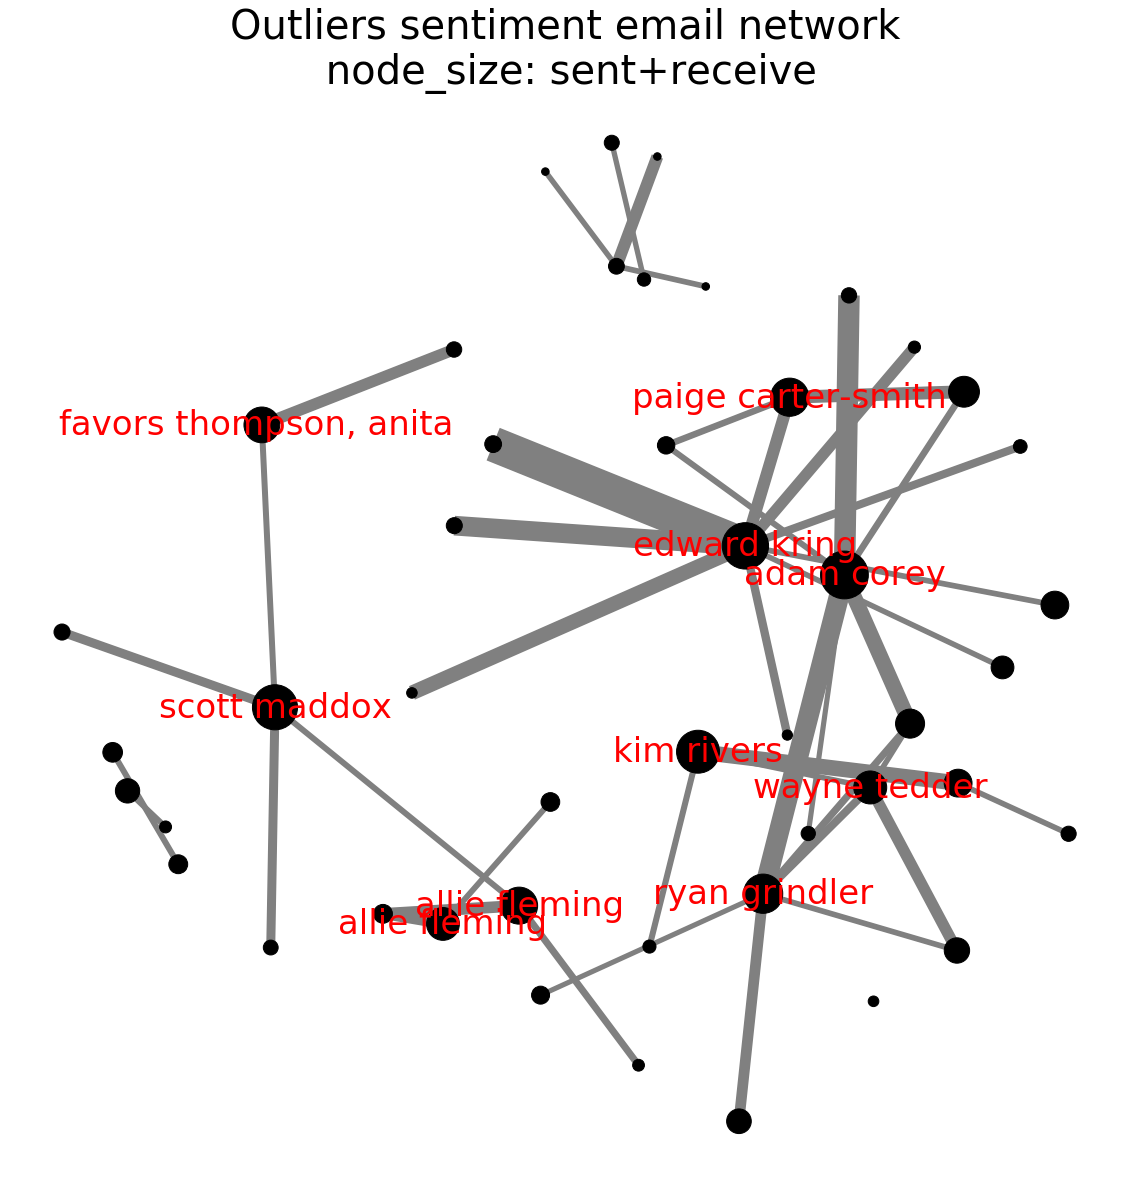

In [323]:
G = nx.Graph()
edge_width = []
node_weight_sender = np.sum(s2r, axis = 1)
node_weight_recipient = np.sum(s2r,axis = 0)
node_weight_total = node_weight_sender + node_weight_recipient
#nb_recipient = np.array(send_to_recipient.shape[0])

# node_weight is the size of node
# the node weight has to be in a specific order(in the order of time when the node first added to the graph),
# cannot just use node_weight_total
node_weight = []
for i in range(s2r.shape[0]):
    for j in range(i,s2r.shape[0]):
        # if there is more than 1 email between these 2 people, add node if haven't add. Add edge.
        if s2r[i,j] + s2r[j,i] > 5:
            if id2name[i] not in G.nodes():
                G.add_node(id2name[i])
                node_weight.append(node_weight_total[i])
            if id2name[j] not in G.nodes():
                    G.add_node(id2name[j])
                    node_weight.append(node_weight_total[j])
            # To disable edges temporarily, comment out the next line. The spring will not take them into account
            G.add_edge(id2name[i], id2name[j],weight= 2/(s2r[i,j] + s2r[j,i] + 0.5*(node_weight_total[i]+ node_weight_total[j])))
            edge_width.append(s2r[i,j] + s2r[j,i])
print('done adding edges and nodes')



# find who should be labeled
node_have_label = {}
for i in range(s2r.shape[0]):
    if node_weight_total[i]>100 and id2name[i] in G.nodes():
        print(id2name[i],i)
        node_have_label[id2name[i]] = id2name[i][0]+' '+id2name[i][1]

# edge_width is actrually edge strength. Bigger strength will lead to shorter distance
# edge_width = np.sqrt(np.array(edge_width))
edge_width = 1*(np.array(edge_width))

node_weight = 10*(np.array(node_weight))

print('done adding labels')

plt.figure(figsize=(20,20))
# calculating node positions
pos = nx.spring_layout(G,iterations=50)
print('done calculating position')

nx.draw_networkx_nodes(G, pos, node_size= node_weight,node_color = 'black')
nx.draw_networkx_edges(G, pos, width= edge_width, edge_color = 'grey')
nx.draw_networkx_labels(G, pos, labels= node_have_label, font_size=34, font_color = 'red', font_family='sans-serif')
plt.title('Outliers sentiment email network\n node_size: sent+receive', fontsize=40)
plt.axis('off')

done adding edges and nodes
('adam', 'corey', 'acorey@gunster.com') 147.14206349206347
('alison', 'faris', 'afaris@comcast.net') 31.74264705882353
('allie', 'fleming', 'allison.fleming@talgov.com') 132.4952380952381
('ashley', 'edwards', 'ashley.edwards@talgov.com') 44.31111111111112
('edward', 'kring', 'edward.kring@talgov.com') 202.0972582972583
('favors thompson, anita', '', 'anita.favors.thompson@talgov.com') 98.41489898989897
('gary', 'yordon', 'gary@govinc.net') 35.75
('jay', 'townsend', 'jay.townsend@talgov.com') 56.00238095238096
('kim', 'rivers', 'kim@inkbridge.com') 136.79090996722576
('nancy', 'miller', 'nancy.miller@talgov.com') 66.88968253968252
('paige', 'carter-smith', 'paige@govinc.net') 66.2016806722689
('roxanne', 'manning', 'roxanne.manning@talgov.com') 36.20238095238095
('ryan', 'grindler', 'rgrindler@101tally.com') 78.48015873015872
('scott', 'maddox', 'scott.maddox@talgov.com') 92.32777777777778
('wayne', 'tedder', 'wayne.tedder@talgov.com') 60.3718253968254
done 

(-1.0884710173341137,
 0.8578913640163851,
 -0.9701882156151395,
 1.0370452536329586)

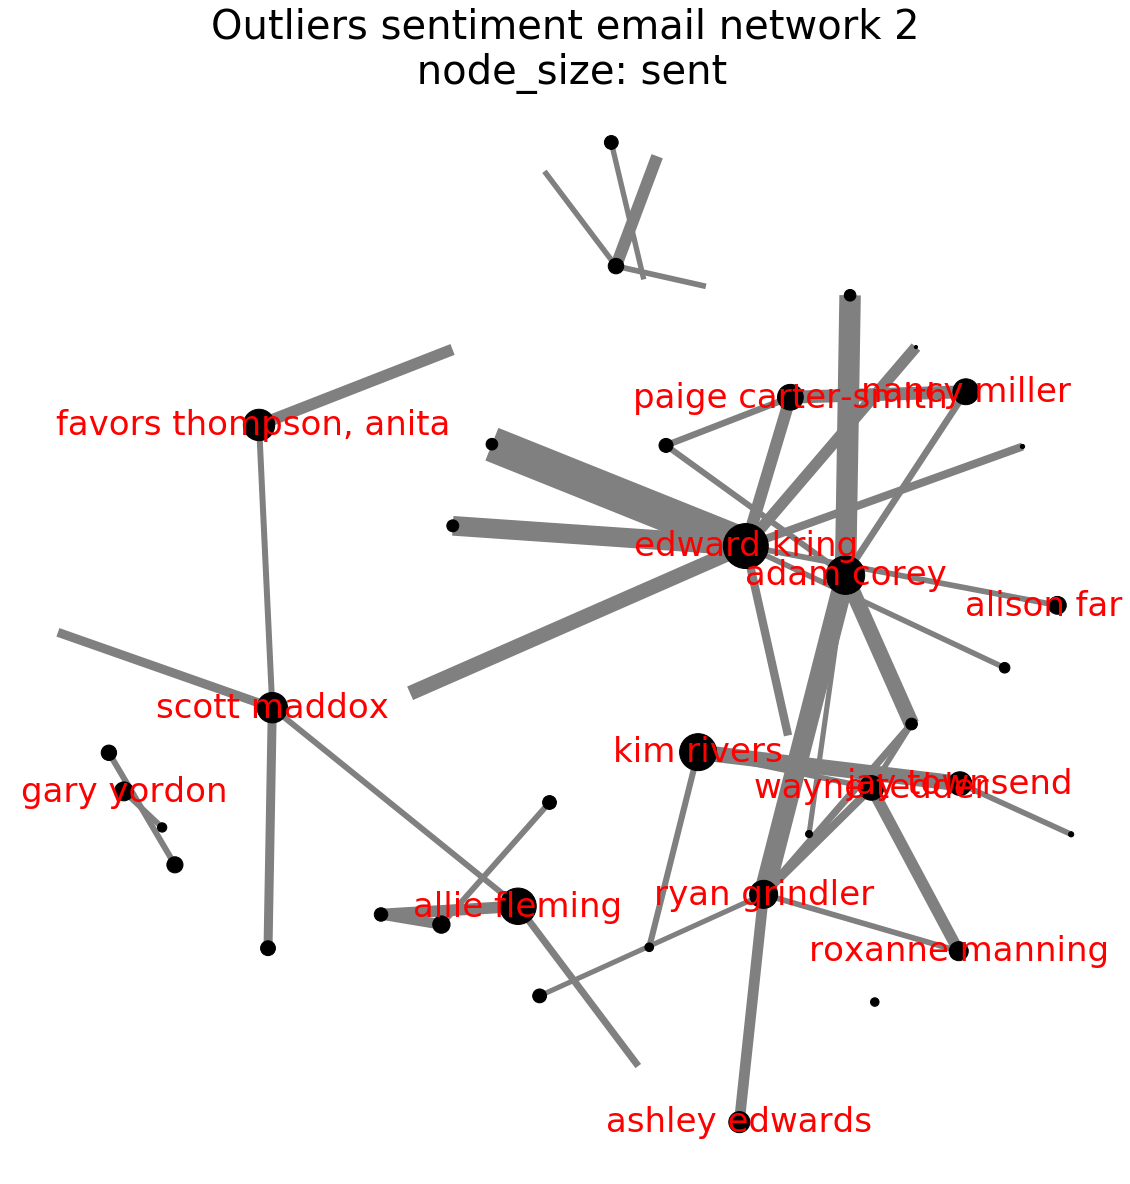

In [324]:
G = nx.Graph()
edge_width = []
node_weight_sender = np.sum(s2r, axis = 1)
node_weight_recipient = np.sum(s2r,axis = 0)
node_weight_total = node_weight_sender + node_weight_recipient
#nb_recipient = np.array(send_to_recipient.shape[0])

# node_weight is the size of node
# the node weight has to be in a specific order(in the order of time when the node first added to the graph),
# cannot just use node_weight_total
node_weight = []
for i in range(s2r.shape[0]):
    for j in range(i,s2r.shape[0]):
        # if there is more than 1 email between these 2 people, add node if haven't add. Add edge.
        if s2r[i,j] + s2r[j,i] > 5:
            if id2name[i] not in G.nodes():
                G.add_node(id2name[i])
                node_weight.append(node_weight_sender[i])
            if id2name[j] not in G.nodes():
                    G.add_node(id2name[j])
                    node_weight.append(node_weight_sender[j])
            # To disable edges temporarily, comment out the next line. The spring will not take them into account
            G.add_edge(id2name[i], id2name[j],weight= 2/(s2r[i,j] + s2r[j,i] + 0.5*(node_weight_total[i]+ node_weight_total[j])))
            edge_width.append(s2r[i,j] + s2r[j,i])
print('done adding edges and nodes')



# find who should be labeled
node_have_label = {}
for i in range(s2r.shape[0]):
    if node_weight_sender[i]>=30 and id2name[i] in G.nodes():
        print(id2name[i], node_weight_sender[i])
        node_have_label[id2name[i]] = id2name[i][0]+' '+id2name[i][1]

# edge_width is actrually edge strength. Bigger strength will lead to shorter distance
# edge_width = np.sqrt(np.array(edge_width))
edge_width = 1*(np.array(edge_width))

node_weight = 10*(np.array(node_weight))

print('done adding labels')

plt.figure(figsize=(20,20))
# calculating node positions
# pos = nx.spring_layout(G,iterations=30)
print('done calculating position')

nx.draw_networkx_nodes(G, pos, node_size= node_weight,node_color = 'black')
nx.draw_networkx_edges(G, pos, width= edge_width, edge_color = 'grey')
nx.draw_networkx_labels(G, pos, labels= node_have_label, font_size=34, font_color = 'red', font_family='sans-serif')
plt.title('Outliers sentiment email network 2\n node_size: sent', fontsize=40)
plt.axis('off')

In [325]:
# kim rivers
idx_kim = []
for i in range(len(from_list)):
    if from_list[i] == ('kim', 'rivers', 'kim@inkbridge.com'):
        idx_kim.append(i)
df_kim = df_outliers.iloc[idx_kim]
len(df_kim)

35

In [329]:
df_kim

,From,Sent,To,CC,Subject,Body,textblob_sentiment,nltk_sentiment
8,"('kim', 'rivers', 'kim@inkbridge.com')",2012-05-25 12:45:00,"[('jay', 'townsend', 'jay.townsend@talgov.com')]",[],[],"['', 'Great. How does Friday look?', 'Kim Rive...","[0.8, 0.75]","[0.6249, 0.0, 0.709, 0.291]"
30,"('kim', 'rivers', 'kim@inkbridge.com')",2012-08-23 10:16:00,"[('frank', 'watson', 'fwatson@btnc.tv')]","[('kim', 'rivers', 'kim@inkbridge.com'), ('bra...",[],"['', 'We can do late Thursday if that works.',...","[-0.3, 0.6]","[0.0, 0.0, 1.0, 0.0]"
294,"('kim', 'rivers', 'kim@inkbridge.com')",2013-03-26 09:02:00,"[('wayne', 'tedder', 'wayne.tedder@talgov.com')]",[],[],"['', 'How did it go? Sorry I was unable to joi...","[-0.5, 0.75]","[-0.0772, 0.14, 0.86, 0.0]"
308,"('kim', 'rivers', 'kim@inkbridge.com')",2013-03-29 18:56:00,"[('ken', 'morris', 'morrisk@leoncountyfl.gov')]","[('kim', 'rivers', 'kim@inkbridge.com'), ('jay...",[],"['', 'Thats a good thought.. Let me check with...","[0.7, 0.6000000000000001]","[0.4404, 0.0, 0.707, 0.293]"
337,"('kim', 'rivers', 'kim@inkbridge.com')",2013-04-08 20:52:00,"[('favors thompson, anita', '', 'anita.favors....",[],[],"['', 'I board a flight in 45 minutes... If we ...","[0.7, 0.6000000000000001]","[0.4404, 0.0, 0.854, 0.146]"
370,"('kim', 'rivers', 'kim@inkbridge.com')",2013-04-22 10:10:00,"[('stephanie', 'holloway', 'holloways@leoncoun...","[('curtis', 'richardson', 'cabaide@aol.com'), ...",[],"['Passcode: 49116657', '', 'Please note the be...","[-0.4125, 0.3]","[0.3802, 0.0, 0.925, 0.075]"
441,"('kim', 'rivers', 'kim@inkbridge.com')",2013-05-20 13:03:00,"[('jessica', 'miller', 'jessica.miller@talgov....","[('stephanie', 'holloway', 'holloways@leoncoun...",[],"['', 'Great - we have lots of volunteers but t...","[0.7125, 0.625]","[0.7789, 0.0, 0.569, 0.431]"
456,"('kim', 'rivers', 'kim@inkbridge.com')",2013-05-24 18:40:00,"[('ken', 'poole', 'kpoole@crec.net')]","[('ken', 'morris', 'morrisk@leoncountyfl.gov')...",[],"['', 'I think we should reschedule the meeting...","[-0.21250000000000002, 0.375]","[0.3818, 0.0, 0.927, 0.073]"
532,"('kim', 'rivers', 'kim@inkbridge.com')",2013-06-21 16:11:00,"[('jessica', 'miller', 'jessica.miller@talgov....","[('kim', 'rivers', 'kim@inkbridge.com'), ('gil...",[],"['', '3:00 is great - Jt and I will be there a...","[0.8, 0.75]","[0.7964, 0.0, 0.649, 0.351]"
573,"('kim', 'rivers', 'kim@inkbridge.com')",2013-07-08 11:57:00,"[('sheila', 'salyer', 'sheila.salyer@talgov.co...",[],[],"['', 'Awesome - thanks! I look forward to the ...","[0.625, 0.6]","[0.807, 0.0, 0.622, 0.378]"


In [326]:
textblob_sentiment = df_kim['textblob_sentiment'].values.tolist()
for i in range(len(textblob_sentiment)):
    textblob_sentiment[i] = eval(textblob_sentiment[i])
for i in range(len(df_kim)):
    print('*'*25,'Kim', 'email NO.',i,'sentiment:',textblob_sentiment[i][0],'*'*25)
    print(df_kim.iloc[i]['Body'])

************************* Kim email NO. 0 sentiment: 0.8 *************************
['', 'Great. How does Friday look?', 'Kim Rivers, Principal', 'e kim@inkbridge.net', 'c 850.508.0261', 'f 850.576.9162']
************************* Kim email NO. 1 sentiment: -0.3 *************************
['', 'We can do late Thursday if that works.', 'Kim Rivers, Principal', 'e kim@inkbridge.net', 'c 850.508.0261', 'f 850.576.9162']
************************* Kim email NO. 2 sentiment: -0.5 *************************
['', 'How did it go? Sorry I was unable to join...']
************************* Kim email NO. 3 sentiment: 0.7 *************************
['', 'Thats a good thought.. Let me check with him.']
************************* Kim email NO. 4 sentiment: 0.7 *************************
['', 'I board a flight in 45 minutes... If we dont connect tonight when would be a good time to chat', 'tomorrow?']
************************* Kim email NO. 5 sentiment: -0.4125 *************************
['Passcode: 49116657'

In [327]:
# adam corey
idx_adam = []
for i in range(len(from_list)):
    if from_list[i][0] == 'adam' and from_list[i][1] ==  'corey':
        idx_adam.append(i)
df_adam = df_outliers.iloc[idx_adam]
df_adam


,From,Sent,To,CC,Subject,Body,textblob_sentiment,nltk_sentiment
31,"('adam', 'corey', 'acorey@gunster.com')",2012-08-24 20:00:00,"[('f2204', 'l2204', 'elizabeth.dillon@talgov.c...",[],[],"['', 'Lieutenant Dillon,', 'I had a wonderful ...","[0.6071428571428571, 0.6171428571428572]","[0.9184, 0.076, 0.572, 0.352]"
36,"('adam', 'corey', 'acorey@gunster.com')",2012-09-20 10:09:00,"[('apasini@comcast.net""', '', 'apasini@comcast...","[('gene', 'crawford', 'gene_crawford'), ('nazz...",[],"['', 'Excellent. Thank you!']","[1.0, 1.0]","[0.7574, 0.0, 0.133, 0.867]"
44,"('adam', 'corey', 'adam@101tallahassee.com')",2012-10-30 12:37:00,"[('gil', 'ziffer', 'gil@ziffberry.com')]",[],['How about the 13th? We could a meal or I can...,"['Adam Corey', 'Gunster Law Firm', '215 South ...","[-0.2, 0.4]","[0.0, 0.0, 1.0, 0.0]"
48,"('adam', 'corey', 'acorey@gunster.com')",2012-11-04 18:19:00,"[('pat delacy poitinger', '', 'pat delacy poit...","[('james.bird', '', 'james.bird@talgov.com'), ...",[],"['', 'Pat,', 'Im sorry to hear this happened. ...","[-0.16666666666666666, 0.5333333333333333]","[0.0772, 0.125, 0.742, 0.133]"
50,"('adam', 'corey', 'acorey@gunster.com')",2012-11-08 09:36:00,"[('rick', 'mccraw', 'richard.mccraw@talgov.com')]","[('jesse', 'jabot', 'jessejabot@hookedonharrys...",[],"['', 'Rick,', 'Sorry for the delay. We have a ...","[-0.16666666666666666, 0.5333333333333333]","[0.0772, 0.096, 0.827, 0.077]"
...,...,...,...,...,...,...,...,...
1456,"('adam', 'corey', 'acorey@gunster.com')",2017-03-29 17:42:00,"[('jessica', 'brown', 'jessicae.brown@talgov.c...",[],[],"['', 'Awesome. Thank you!', 'Adam Corey', 'Fou...","[1.0, 1.0]","[0.784, 0.0, 0.654, 0.346]"
1483,"('adam', 'corey', 'adam@unconventionalstrategi...",2017-04-24 15:42:00,"[('michelle', 'hill', 'michelle.hill@talgov.co...","[('ashley', 'sparks', 'ashley@edisontally.com')]",[],"['', 'Good luck with the event Michelle.', 'Ad...","[0.85, 0.8]","[0.9117, 0.0, 0.636, 0.364]"
1484,"('adam', 'corey', 'acorey@gunster.com')",2017-04-24 15:42:00,"[('michelle', 'hill', 'michelle.hill@talgov.co...","[('ashley', 'sparks', 'ashley@edisontally.com')]",[],"['', 'Good luck with the event Michelle.', 'Ad...","[0.85, 0.8]","[0.9117, 0.0, 0.636, 0.364]"
1486,"('adam', 'corey', 'acorey@gunster.com')",2017-04-28 10:12:00,"[('clint', 'smith', 'clinton.smith@talgov.com')]",[],[],"['', 'Clint,', 'Thank you again for getting me...","[0.64375, 0.8625]","[0.9041, 0.0, 0.766, 0.234]"


In [328]:
textblob_sentiment = df_adam['textblob_sentiment'].values.tolist()
for i in range(len(textblob_sentiment)):
    textblob_sentiment[i] = eval(textblob_sentiment[i])
for i in range(len(df_adam)):
    print('*'*25,'Adam', 'email NO.',i,'sentiment:',textblob_sentiment[i][0],'*'*25)
    print(df_adam.iloc[i]['Body'])

************************* Adam email NO. 0 sentiment: 0.6071428571428571 *************************
['', 'Lieutenant Dillon,', 'I had a wonderful visit with Investigator Rob Rohrbacher. Youre right, he is a great guy and I appreciate you', 'connecting him with us. I think we have a good plan in place.', 'Thanks again!', 'Adam Corey']
************************* Adam email NO. 1 sentiment: 1.0 *************************
['', 'Excellent. Thank you!']
************************* Adam email NO. 2 sentiment: -0.2 *************************
['Adam Corey', 'Gunster Law Firm', '215 South Monroe Street', 'Suite 601', 'Tallahassee, FL 32301']
************************* Adam email NO. 3 sentiment: -0.16666666666666666 *************************
['', 'Pat,', 'Im sorry to hear this happened. Rob and Eric, can you please address this with the tenants?', 'Thanks,', 'Adam Corey', 'Gunster Law Firm', '215 South Monroe Street', 'Suite 601', 'Tallahassee, FL 32301']
************************* Adam email NO. 4 sent

In [263]:
df_outliers.iloc[1487]['Body']

"['', 'Rob,', 'Thank you for keeping me in the loop on this. I hope you have a great weekend.', 'Adam Corey', 'President', 'Unconventional Strategies', '423-1 All Saints Street', 'Tallahassee, FL 32301', 'www.unconventionalstrategies.com']"

In [264]:
for i in range(len(unique_people)):
    if unique_people[i][0] == 'allie' and unique_people[i][1] == 'fleming':
        print(i)

75
76
77


In [265]:
unique_people[77:80]

[('allie', 'fleming', 'amerzerfleming@yahoo.com'),
 ('alliefleming', '', 'alliefleming_'),
 ('allison', '', 'allison_')]

In [270]:
edward_to_paige_emails = []
for i in range(len(df_outliers)):
    if from_list[i] == ('edward', 'kring', 'edward.kring@talgov.com') and (('paige', 'carter-smith', 'paige@govinc.net') in to_list[i] or ('paige', 'carter-smith', 'paige@govinc.net') in cc_list[i]):
        edward_to_paige_emails.append(i)

1349
1358
1362
1380
1381
1383
1384
1390
1395
1396
1400
1401
1403
1404
1405
1406
1407
1408
1415
1416
1429
1431
1432
1438
1448
1449
1452
1453
1457
1465
1467
1469
1470
1499
1504
1512


In [271]:
df_edward_to_paige = df_outliers.iloc[edward_to_paige_emails]
df_edward_to_paige = df_edward_to_paige.reset_index(drop=True)
df_edward_to_paige

,From,Sent,To,CC,Subject,Body,textblob_sentiment,nltk_sentiment
0,"('edward', 'kring', 'edward.kring@talgov.com')",2017-01-20 11:57:00,"[('alison', 'faris', 'afaris@comcast.net'), ('...",[],[],"['', 'FYI:', 'Thanks,', 'Eddie', 'Edward Mart ...","[-0.43333333333333335, 0.7333333333333334]","[0.8143, 0.0, 0.655, 0.345]"
1,"('edward', 'kring', 'edward.kring@talgov.com')",2017-01-23 11:03:00,"[('paige', 'carter-smith', 'paige@govinc.net')]",[],['Fwd: Trolley Meeting'],"['', 'Thanks,', 'Eddie', 'Edward Mart Kring', ...","[-0.43333333333333335, 0.7333333333333334]","[0.7096, 0.0, 0.731, 0.269]"
2,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-03 16:21:00,"[('jay', 'johansen', 'jay.johansen@talgov.com')]","[('fred', 'harris', 'fred.harris@talgov.com'),...",['Re: Vanity short codes'],"['', 'All- weve decided to hold on Vanity Shor...","[-0.325, 0.625]","[0.6124, 0.056, 0.769, 0.175]"
3,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-15 16:51:00,"[('paige', 'carter-smith', 'paige@govinc.net')]",[],['Fwd: Guide Update'],"['', 'What do we need to add to this? A signat...","[-0.43333333333333335, 0.7333333333333334]","[0.7399, 0.0, 0.806, 0.194]"
4,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-16 08:48:00,"[('paige', 'carter-smith', 'paige@govinc.net')]",[],['Fwd: Guide Update'],"['', 'Thoughts on this revision?', 'Thanks,', ...","[-0.43333333333333335, 0.7333333333333334]","[0.7096, 0.0, 0.772, 0.228]"
5,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-17 09:45:00,"[('paige', 'carter-smith', 'paige@govinc.net')]",[],['Fwd: test'],"['', 'Does this look good to you?', 'Thanks,',...","[-0.15000000000000002, 0.7]","[0.8316, 0.0, 0.705, 0.295]"
6,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-17 10:27:00,"[('paige', 'carter-smith', 'paige@govinc.net')]",[],[],"['', 'Did the links work for you?', 'Thanks,',...","[-0.43333333333333335, 0.7333333333333334]","[0.7096, 0.0, 0.789, 0.211]"
7,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-20 13:22:00,"[('mike', 'kissane', 'mike_kissane')]","[('fred', 'harris', 'fred.harris@talgov.com'),...",[],"['', 'Seems like cascades park went down. Not ...","[-0.36388888888888893, 0.6222222222222222]","[0.8126, 0.0, 0.756, 0.244]"
8,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-22 13:48:00,"[('christina', 'johnson', 'christina@on3pr.com...","[('alison', 'faris', 'afaris@comcast.net')]",[],"['Mondays', 'Fantastic, thanks Christina! When...","[-0.27, 0.82]","[0.8883, 0.054, 0.672, 0.274]"
9,"('edward', 'kring', 'edward.kring@talgov.com')",2017-02-22 16:03:00,"[('trevor', 'faulkner', 'trevor_faulkner')]","[('paige', 'carter-smith', 'paige@govinc.net')]",[],"['Trevor, we would like to request a T@Night i...","[-0.2733333333333333, 0.5733333333333334]","[0.7906, 0.0, 0.86, 0.14]"


In [274]:
textblob_sentiment = df_edward_to_paige['textblob_sentiment'].values.tolist()
for i in range(len(textblob_sentiment)):
    textblob_sentiment[i] = eval(textblob_sentiment[i])

In [277]:
for i in range(len(df_edward_to_paige)):
    print('*'*25,'Edward to Paige', 'email NO.',i,'sentiment:',textblob_sentiment[i][0],'*'*25)
    print(df_edward_to_paige.iloc[i]['Body'])

************************* Edward to Paige email NO. 0 sentiment: -0.43333333333333335 *************************
['', 'FYI:', 'Thanks,', 'Eddie', 'Edward Mart Kring', 'Citizen Engagement Ambassador,', 'Department of Communications', 'Office: (850) 891-8081', 'Cell: (850) 545-2095', 'edward.kring@talgov.com', '']
************************* Edward to Paige email NO. 1 sentiment: -0.43333333333333335 *************************
['', 'Thanks,', 'Eddie', 'Edward Mart Kring', 'Citizen Engagement Ambassador,', 'Department of Communications', 'Office: (850) 891-8081', 'Cell: (850) 545-2095', 'edward.kring@talgov.com', 'M']
************************* Edward to Paige email NO. 2 sentiment: -0.325 *************************
['', 'All- weve decided to hold on Vanity Short Codes for now.', 'Thanks,', 'Eddie', 'Edward Mart Kring', 'Citizen Engagement Ambassador,', 'Department of Communications', 'Office: (850) 891-8081', 'Cell: (850) 545-2095', 'edward.kring@talgov.com', 'M']
************************* Edw

In [338]:
negative_email_idx = []
textblob_sentiment = df_outliers['textblob_sentiment'].values.tolist()
for i in range(len(textblob_sentiment)):
    textblob_sentiment[i] = eval(textblob_sentiment[i])
for i in range(len(df_outliers)):
    if textblob_sentiment[i][0]<=-0.75:
        negative_email_idx.append(i)
        
df_negative = df_outliers.iloc[negative_email_idx]
df_negative = df_negative.reset_index(drop = True)
textblob_sentiment = df_negative['textblob_sentiment'].values.tolist()
for i in range(len(textblob_sentiment)):
    textblob_sentiment[i] = eval(textblob_sentiment[i])
for i in range(len(df_negative)):
    print('*'*25, 'Negative Email NO.',i,'sentiment:',textblob_sentiment[i][0],'*'*25)
    print(df_negative.iloc[i]['Body'])

************************* Negative Email NO. 0 sentiment: -0.75 *************************
['Location:', '', 'Com. Maddox; Transmission Line Briefing', 'City Commisison Conf. Rm.', '', 'Start: Mon 12/3/2012 11:00 AM', 'End:', 'Mon 12/3/2012 11:30 AM', 'Show Time As:', 'Tentative', 'Recurrence:', '', '(none)', '', 'Meeting Status: Not yet responded', 'Organizer:', '', 'Fernandez, Rick', '', 'Attendees:', 'Commissioner Maddox', 'Rick Fernandez', 'Rob McGarrah', 'Brian Horton']
************************* Negative Email NO. 1 sentiment: -0.75 *************************
['Mtg w/Anita  Start: Tue 11/12/2013 3:00 PM End: Tue 11/12/2013 4:00 PM Show Time As: Tentative Recurrence:  (none)  Meeting Status: Not yet responded Organizer:  Maddox, Scott', 'Location:', '', 'City Comm mtg', 'Chambers', '', 'Start: Wed 11/13/2013 4:00 PM', 'End:', 'Wed 11/13/2013 7:00 PM', 'Show Time As:', 'Tentative', 'Recurrence:', '', '(none)', '', 'Meeting Status: Not yet responded', 'Organizer:', '', 'Maddox, Scott',

In [334]:
len(negative_email_idx)

101